#Description

notebook to segment foci using otsu-thresholding and watershed/random walker

currently works for 3D. slight adjustment needed for single-plane (2D) data.

<hr>

**input**<br>
stack .tif `Z * X * Y * channels`

**output**<br>
- labels .tif `Z * X * Y`

*Note: The output will consist of labels of len(Z) = 1. To create 3D segmentations, use `find_overlapping_masks.ipynb` and `merge_masks.ipynb`*

<hr>

# References
https://scikit-image.org/skimage-tutorials/lectures/three_dimensional_image_processing.html

## segmentation
- https://scipy-lectures.org/packages/scikit-image/#histogram-based-method-otsu-thresholding

- https://scipy-lectures.org/packages/scikit-image/#labeling-connected-components-of-a-discrete-image

- https://scipy-lectures.org/packages/scikit-image/#watershed-segmentation

- https://scipy-lectures.org/packages/scikit-image/#random-walker-segmentation


# Notebook initialisation

## Imports

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')#, force_remount=True)

from datetime import datetime
import os
import json
from pprint import pprint

import copy
import skimage
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

import numpy as np
import cv2
import numpy.ma as ma
import pandas as pd
import scipy

#from cellpose.utils import outlines_list

from skimage.segmentation import watershed, random_walker
from skimage import morphology
from skimage import measure
from skimage.feature import peak_local_max
from scipy import ndimage

import tifffile



Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


## Custom colormap
- gradient colormaps going from black to
1. red `redmap`
2. green `greenmap`
3. blue `bluemap`

Useful for plotting the channels separately.

In [ ]:
from matplotlib.colors import LinearSegmentedColormap
#https://stackoverflow.com/questions/57268627/matplotlib-color-gradient-between-two-colors

colors = [(0, 0, 0), (1, 0, 0)] # first color is black, last is red
redmap = LinearSegmentedColormap.from_list(
        "Black2Red", colors, N=100)

colors = [(0, 0, 0), (0, 1, 0)] # first color is black, last is green
greenmap = LinearSegmentedColormap.from_list(
        "Black2Green", colors, N=100)

colors = [(0, 0, 0), (0, 0, 1)] # first color is black, last is blue
bluemap = LinearSegmentedColormap.from_list(
        "Black2Blue", colors, N=100)



## Custom functions

## helper

## pre-processing: image enhancement

In [ ]:
def gaussian_smooth(img_matrix, sigma, smooth_per_plane=True):
    """apply Gaussian smoothing to a 2D/3D image matrix

    Args:
        img_matrix (numpy.ndarray): input img matrix to be smoothed.
        sigma (float): standard deviation for Gaussian kernel.
        smooth_per_plane (bool): whether to apply smoothing to each 2D plane
                                 separately  (True) or apply smoothing to the
                                 entire 3D volume (False). Default: False

    Returns:
        numpy.ndarray: The smoothed img using gaussian smoothing.
    """
    img_matrix = img_matrix.astype(np.float32)

    if smooth_per_plane:
        smoothed_matrix = np.zeros_like(img_matrix)
        for iplane in range(img_matrix.shape[0]):
            smoothed_matrix[iplane] = skimage.filters.gaussian(
                                        img_matrix[iplane], sigma=sigma)
    else:
        smoothed_matrix = skimage.filters.gaussian(img_matrix, sigma=sigma)

    return smoothed_matrix

def increase_exposure_per_plane(img_matrix, q=(0.005, 0.995), gamma=1, show=True, figsize=(10,10)):
    """Wrapper for increase_exposure() per plane
    """
    img_enhanced = []
    for img_plane in img_matrix:
        img_plane = increase_exposure(img_plane, q=q, gamma=gamma, show=show, figsize=figsize)
        img_enhanced.append(img_plane)

    return np.array(img_enhanced)

def increase_exposure(img_matrix, q=(0.005, 0.995), gamma=1, show=True, figsize=(10,10)):
    """Increase contrast between pixels of an img.

    Args:
        img_matrix (ndarray): 2D or 3D image matrix
        q (tup of 2 floats): min-max percentile range to retain. Default:
                             (0.005, 0.995)

    Returns:
        ndarray, enhanced img_matrix

    https://scikit-image.org/skimage-tutorials/lectures/three_dimensional_image_processing.html
    """
    vmin, vmax = np.quantile(img_matrix, q=q)

    #increase contrast by clipping extremes
    img_enhanced = skimage.exposure.rescale_intensity(
        img_matrix,
        in_range=(vmin, vmax),
        out_range=np.int8)

    #increase contrast by adjusting gamma
    img_enhanced = skimage.exposure.adjust_gamma(img_enhanced, gamma=gamma)

    if show: #plot original and enhanced img next to each other
        if len(img_enhanced.shape) == 2:
            fig, axes = plt.subplots(1,2, figsize=figsize)
            axes[0].imshow(img_matrix, cmap='gray')
            axes[0].set_title("original")

            axes[1].imshow(img_enhanced, cmap='gray')
            axes[1].set_title(f" increased contrast ({q[0]} - {q[1]})")

            for ax in axes: ax.axis("off")
            plt.tight_layout()
            plt.show();

        else: #show range, steps of 10
            for iplane in np.arange(0, img_matrix.shape[0], 10):
                fig, axes = plt.subplots(1,2, figsize=figsize)
                axes[0].imshow(img_matrix[iplane, :,:], cmap='gray')
                axes[0].set_title("original")

                axes[1].imshow(img_enhanced[iplane, :, :], cmap='gray')
                axes[1].set_title(f" increased contrast ({q[0]} - {q[1]})")

                for ax in axes: ax.axis("off")

                plt.suptitle(f"iplane = {iplane}", y=0.8)
                plt.tight_layout()
                plt.show();

    return img_enhanced

def smooth(binary_matrix, smooth_kernel=(2,2), erode=2, dilate=2, order_erosion_dilation='first_erode'):
    """ Smooth edges using erosion and dilation

    Args:
        binary_matrix (ndarray): 2D or 3D matrix. If a 3D matrix is provided,
                                 Each z will be smoothed separately
    """
    if len(binary_matrix.shape) not in [2,3]:
        raise ValueError("Provided binary matrix has dimensions"  +
                         f"{binary_matrix.shape}. Only 2D and 3D matrices " +
                         "are supported.")

    kernel = np.ones(smooth_kernel, np.uint8)

    #smoothing, 2D
    if len(binary_matrix.shape) == 2:
        if order_erosion_dilation == 'first_erode':
            binary_matrix_smoothed = cv2.erode(binary_matrix.astype('uint8'),
                                            kernel, iterations=erode)
            binary_matrix_smoothed = cv2.dilate(binary_matrix_smoothed.astype('uint8'),
                                                kernel, iterations=dilate)

        elif order_erosion_dilation == 'first_dilate':
            binary_matrix_smoothed = cv2.dilate(binary_matrix.astype('uint8'),
                                                kernel, iterations=dilate)
            binary_matrix_smoothed = cv2.erode(binary_matrix_smoothed.astype('uint8'),
                                            kernel, iterations=erode)

    #smoothing, 3D
    if len(binary_matrix.shape) == 3:
        binary_matrix_smoothed = copy.deepcopy(binary_matrix)
        for iplane in range(binary_matrix.shape[0]):
            single_plane = binary_matrix_smoothed[iplane,:,:]

            if order_erosion_dilation == 'first_erode':
                single_plane_smoothed = cv2.erode(single_plane.astype('uint8'),
                                                kernel, iterations=erode)
                single_plane_smoothed = cv2.dilate(single_plane_smoothed.astype('uint8'),
                                                    kernel, iterations=dilate)

            elif order_erosion_dilation == 'first_dilate':
                single_plane_smoothed = cv2.dilate(single_plane.astype('uint8'),
                                                    kernel, iterations=dilate)
                single_plane_smoothed = cv2.erode(single_plane_smoothed.astype('uint8'),
                                                kernel, iterations=erode)


            binary_matrix_smoothed[iplane, :, :] = single_plane_smoothed

    return binary_matrix_smoothed

## Segmentation

### semantic segmentation

In [ ]:
def binarise_with_otsu_per_plane(img_matrix, mask_matrix=None, mode='binary', verbose=False):
    """Binarize an image matrix using Otsu's thresholding method.

    Args:
        img_matrix (ndarray): 2D or 3D image matrix.
        mask_matrix (ndarray, optional): 2D or 3D label matrix. If provided,
            only regions within labels are considered for Otsu thresholding.
        verbose (bool): Whether to print verbose output. (Default: False)

    Returns:
        ndarray: Binary matrix with the same dimensions as img_matrix,
                 where 0: background, 1: foreground
    """
    otsu_matrix = []
    if mask_matrix is None:
        mask_matrix = [None] * len(img_matrix)
    for img_plane, mask_plane in zip(img_matrix, mask_matrix):
        otsu_plane = binarise_with_otsu(img_plane, mask_matrix=mask_plane, mode=mode, verbose=verbose)
        otsu_matrix.append(otsu_plane)

    return np.array(otsu_matrix)

In [ ]:
def binarise_with_otsu(img_matrix, mask_matrix=None, mode='binary', verbose=False):
    """Binarize an image matrix using Otsu's thresholding method.

    Args:
        img_matrix (ndarray): 2D or 3D image matrix.
        mask_matrix (ndarray, optional): 2D or 3D label matrix. If provided,
            only regions within labels are considered for Otsu thresholding.
        mode (str, 'binary' or 'multi'): Whether to use two-level or multi-level otsu thresholding.
        verbose (bool): Whether to print verbose output. (Default: False)

    Returns:
        ndarray: Binary matrix with the same dimensions as img_matrix,
                 where 0: background, 1: foreground
    """
    if isinstance(mask_matrix, np.ndarray):  # Otsu only within labelled regions
        if verbose:
            print("OTSU, EXCLUDE BG")

        if mode=='binary':
            img_labelled_regions = img_matrix[mask_matrix != 0]
            otsu_threshold = skimage.filters.threshold_otsu(img_labelled_regions)
            otsu_matrix = img_labelled_regions > otsu_threshold
        elif mode=='multi':
            thresholds = skimage.filters.threshold_multiotsu(img_labelled_regions)
            otsu_matrix = np.digitize(img_labelled_regions, bins=thresholds)
    else:  # Otsu on entire image
        if verbose:
            print("OTSU, INCLUDE BG")

        if mode=='binary':
            otsu_threshold = skimage.filters.threshold_otsu(img_matrix)
            otsu_matrix = img_matrix > otsu_threshold
        elif mode=='multi':
            thresholds = skimage.filters.threshold_multiotsu(img_matrix)
            otsu_matrix = np.digitize(img_matrix, bins=thresholds)


    return otsu_matrix

### instance segmentation

In [ ]:
def binarised2label(binary_matrix, intensity_matrix=None, algorithm='watershed',
                    compactness=0, beta=130, instance_kernel=(3,3), min_distance=6):
    """Convert a 2D binary matrix into a label matrix.

    Args:
        binary_matrix (ndarray): 2D binary matrix.
        intensity_matrix (ndarray, optional): 2D intensity matrix. Required for
                                              random walker algorithm.
        algorithm (str): {'none', 'watershed', 'random_walker'}. The algorithm
                         used for label conversion. Default: 'watershed'.
        compactness (float): Used in watershed algorithm, default: 0.
        beta (int): Used in random walker algorithm, default: 130.

    Returns:
        ndarray: 2D label matrix with sequential labels.
    """
    if algorithm not in ['none', 'watershed', 'random_walker']:
        raise ValueError(f'Algorithm {algorithm} not recognized.')

    if algorithm == 'none':
        return measure.label(binary_matrix, background=0)

    # Markers, used in both watershed and random walker
    distance = ndimage.distance_transform_edt(binary_matrix)
    coords = peak_local_max(distance, min_distance=min_distance, footprint=np.ones(instance_kernel), labels=binary_matrix)
    #markers = morphology.label(coords)

    mask = np.zeros(distance.shape, dtype=bool)
    mask[tuple(coords.T)] = True
    markers, _ = scipy.ndimage.label(mask)

    if algorithm == 'watershed':
        return watershed(-distance, markers, mask=binary_matrix,
                         compactness=compactness)

    if algorithm == 'random_walker':
        markers[np.where(binary_matrix == 0)] = -1  # Ignore bg pixels
        return random_walker(intensity_matrix, markers, beta=beta)



In [ ]:
def binarised2label_3d(binary_matrix, channel_matrix=None, algorithm='watershed', compactness=0, beta=130, instance_kernel=(2,2), min_distance=6):
    """Convert a 3D binary matrix into a label matrix.

    Args:
        binary_matrix (ndarray): 2D binary matrix.
        intensity_matrix (ndarray, optional): 2D intensity matrix. Required for
                                              random walker algorithm.
        algorithm (str): {'none', 'watershed', 'random_walker'}. The algorithm
                         used for label conversion. Default: 'watershed'.
        compactness (float): Used in watershed algorithm, default: 0.
        beta (int): Used in random walker algorithm, default: 130.

    Returns:
        ndarray: 3D label matrix with sequential labels. Every label is 1 plane
                 wide.

    note:
        - This function is binarised2label() for 3D matrices
    """
    nplanes, x, y = binary_matrix.shape

    full_label_matrix = np.empty(shape=(0, x, y))
    max_id = 1

    for iplane in range(nplanes):
        binary_plane_matrix = binary_matrix[iplane, :,:]
        img_plane_matrix = channel_matrix[iplane,:,:]

        label_plane_matrix = binarised2label(binary_plane_matrix, img_plane_matrix, algorithm, compactness, beta, instance_kernel, min_distance)
        label_plane_matrix, _, _ = skimage.segmentation.relabel_sequential(label_plane_matrix, offset = max_id)
        full_label_matrix = np.append(full_label_matrix, [label_plane_matrix], axis=0)

        max_id = np.unique(label_plane_matrix)[-1] + 1

    return full_label_matrix

## Post processing

In [ ]:
def shift_labels(matrix, offset_x, offset_y):
    """Shift elements within a 3D matrix by a specified offset in x and/or y

    Args:
        matrix (ndarray): input 3D matrix
        offset_x (int): size of shift elements to the right (positive) or
                        to the left (if negative) (i.e number of columns)
        offset_y (int): size of shift elements downwards (if positive) or
                        upwards (if negative) (i.e number of rows)

    Returns:
        ndarray: shifted version of the input matrix with elements adjusted
                 based on the provided offsets
    """
    if len(matrix.shape) != 3:
        raise ValueError('shift_labels() requires a 3D matrix.' +
                         f'input matrix has shape {matrix.shape}')

    padded_arr = copy.deepcopy(matrix)

    #offset_x
    if offset_x > 0:
        padded_arr = np.array([np.pad(plane, ((0, 0), (offset_x, 0)),
                                      mode='constant', constant_values=0)
                                      for plane in padded_arr])
        padded_arr = padded_arr[:, :matrix.shape[1], :] #cut to original size

    elif offset_x < 0:
        padded_arr = np.array([np.pad(plane, ((0, -offset_x), (0, 0)),
                                      mode='constant', constant_values=0)
                                      for plane in padded_arr])
        padded_arr = padded_arr[:, -offset_x:, :]

    print('after x offset: ', padded_arr.shape)

    #offset_y
    if offset_y > 0:
        padded_arr = np.array([np.pad(plane, ((offset_y, 0), (0, 0)),
                                      mode='constant', constant_values=0)
                                      for plane in padded_arr])
        padded_arr = padded_arr[:, :, :matrix.shape[2]]

    elif offset_y < 0:
        padded_arr = np.array([np.pad(plane, ((0, 0), (0, -offset_y)),
                                      mode='constant', constant_values=0)
                                      for plane in padded_arr])

        padded_arr = padded_arr[:, :, -offset_y:]

    print('after y offset: ', padded_arr.shape)

    return padded_arr

In [ ]:
_ = """offset_x = -10
offset_y = -10

#process data
test = label_matrix[1:3, :, :]
test[:, :5, :] = 999 #add a indicator bar at top
test[:, :, :5] = 999 #add indicator bar on the left

_ = shift_labels(test, offset_x=offset_x, offset_y=offset_y)
mask=ma.masked_where(_[1, :, :] == 0, _[1, :, :], copy=True)

#show
plt.figure(figsize=(30,10))
plt.subplot(1,3,1)
plt.imshow(test[1, :, :])
plt.xlabel("x")
plt.ylabel("y")
plt.title('original')

plt.subplot(1,3,2)
plt.imshow(mask, cmap='Set1')
plt.xlabel("x")
plt.ylabel("y")
plt.title('shifted')

plt.subplot(1,3,3)
plt.imshow(test[1, :, :])
plt.imshow(mask, cmap='Set1', alpha=0.8)
plt.xlabel("x")
plt.ylabel("y")
plt.title('overlay')

plt.suptitle(f"offset_x={offset_x}, offset_y={offset_y}", y=1.02)
plt.tight_layout()
plt.show()"""

## Visualisation

In [ ]:
def print_aligned_data(data):
    """print data in aligned format

    Args:
        data (list of lists): data to be printed. Nested lists represents a
                              rows of data.

    Returns:
        N/A - function returns nothing.

    Example:
    >>> data = [["idx", "name", "img_path", "mask_path"],
                [0, "stack_01", "stack_01_img.tif", "stack_01_labels.tiff"],
                [1, "this_is_a_long_name", "short", "hello_world"]]
    >>> print_aligned_data(data)

        idx    name                   img_path            mask_path
        0      stack_01               stack_01_img.tif    stack_01_labels.tiff
        1      this_is_a_long_name    short               hello_world

    """
    #calculate custom column widths for input data
    column_widths = [max(len(str(item)) for item in column) for column in zip(*data)]

    for row in data:
        print("    ".join(f"{str(item):<{width}}" for item, width
                          in zip(row, column_widths)))

In [ ]:
def plot_binarisation_progress(iplane_plot, img, nchannels, channel_matrix,
                               contrast_matrix, otsu_matrix, smooth_matrix,
                               window=None, xy_inverted=False, save=False):
    """Plot processed image and segmentations for a given iplane_plot.

    Args:
        iplane_plot (int): Index of the plane to plot.
        img (numpy.ndarray): image matrix. shape: (iplanes, x, y, nchannels).
        channel_matrix (numpy.ndarray): Intensity channel matrix.
        contrast_matrix (numpy.ndarray): High contrast matrix.
        otsu_matrix (numpy.ndarray): Otsu binarisation matrix (semantic segmentation).
        smooth_matrix (numpy.ndarray): Smoothed matrix.
        window (tuple of ints, optional): x0,x1,y0,y1
        xy_inverted: read window as y0,y1,x0,x1 instead. Default:False (see notes)
        save (str, optional): if provided, save plot as `save`. Default:False
    Returns:
        N/A

    Notes:
        xy_inverted: option implemented as x and y for subsection viewer in
                     get_subsection.ipynb were inverted.
    """
    # Create a stacked plane
    nchannels=img.shape[-1]
    stacked_plane = np.dstack(tuple(img[iplane_plot, :, :, i] for i in range(nchannels)))

    #Get subsection (optional)
    if isinstance(window, tuple):

        if xy_inverted:
            y0, y1, x0, x1 = window
        else:
            x0, x1, y0, y1 = window

        stacked_plane = stacked_plane[x0:x1, y0:y1, :]
        channel_matrix = channel_matrix[:, x0:x1, y0:y1]
        contrast_matrix = contrast_matrix[:, x0:x1, y0:y1]
        otsu_matrix = otsu_matrix[:, x0:x1, y0:y1]
        smooth_matrix = smooth_matrix[:, x0:x1, y0:y1]

    # Create subplots
    fig, axes = plt.subplots(1, 5, figsize=(25, 5))

    # Plot merged image
    axes[0].set_title("merged")
    axes[0].imshow(stacked_plane)

    # Plot intensity channel
    axes[1].set_title("intensity channel")
    axes[1].imshow(channel_matrix[iplane_plot, :, :], cmap='gray', vmin=0, vmax=255)

    # Plot high contrast
    axes[2].set_title("high contrast")
    axes[2].imshow(contrast_matrix[iplane_plot, :, :], cmap='gray')

    # Plot Otsu binarisation
    axes[3].set_title("otsu binarisation")
    axes[3].imshow(otsu_matrix[iplane_plot, :, :], cmap='gray')

    # Plot smoothed
    axes[4].set_title("smoothed")
    axes[4].imshow(smooth_matrix[iplane_plot, :, :], cmap='gray')

    # Turn off axes
    for ax in axes:
        ax.axis("off")

    # Set title
    plt.suptitle(f"iplane {iplane_plot} (window: {window}; min-max_q: {[min_q, max_q]})", weight="bold")
    plt.tight_layout()

    if save: plt.savefig(save)
    plt.show();

def plot_labels(img, label_matrices, label_names, more_labels=[],
                label_color=['r'], suptitle='', plot_as_outlines=True):
    """
    label_matrices (list of np.arrays): 2d matrices
    label_names (list of str): used as title in plots
    more_labels (list of np.arrays, optional): additional labels to overlay

    returns:
        a fig of subplots
        0. original
        1+. original + label overlay (+ optional other labels)
    """
    nlabels = len(label_matrices)
    fig, axes = plt.subplots(1,nlabels+1, figsize=(5*nlabels+1,5))

    axes[0].imshow(img, cmap='gray')
    axes[0].set_title("original")

    for i, label_matrix in enumerate(label_matrices,1): #foci
        axes[i].imshow(img, cmap='gray')

        #plot outlines
        labels = [label_matrix] + more_labels
        for icolor, label in enumerate(labels):
            if plot_as_outlines:
                for o in outlines_list(label):
                    axes[i].plot(o[:,0], o[:,1], color=label_color[icolor],linewidth=0.7, alpha=1)
            else:
                axes[i].imshow(label_matrix, cmap='nipy_spectral', interpolation='nearest', alpha=1)

        axes[i].set_title(f"{label_names[i-1]} (n={len(np.unique(label_matrix))})") #?? does not seem to work??

    for ax in axes:
        ax.axis("off")

    plt.suptitle(suptitle,y=0.9)
    plt.show();

    return fig

def show_mask(label_matrix, img_matrix, selected_regionids,
              alpha=0.5, zoom_in=True, padding=0):
    """

    Args:
        zoom_in (bool, optional): only works if 1 regionid is provided.
    """
    label_copy = copy.deepcopy(label_matrix)
    img_copy = copy.deepcopy(img_matrix)

    #show single region
    if isinstance(selected_regionids, list):
        label_copy[~np.isin(label_copy, selected_regionids)] = 0

    # zoom in
    if zoom_in and len(selected_regionids) == 1:
        x0,y0,x1,y1 = skimage.measure.regionprops(label_copy)[0].bbox

        xmax = label_copy.shape[0]
        ymax = label_copy.shape[1]
        x0 = (x0 - padding if x0 - padding > 0 else 0)
        y0 = (y0 - padding if y0 - padding > 0 else 0)
        x1 = (x1 + padding if x1 + padding < xmax else xmax)
        y1 = (y1 + padding if y1 + padding < ymax else ymax)

        label_copy = label_copy[x0:x1, y0:y1]
        img_copy = img_copy[x0:x1, y0:y1]

    _ = skimage.color.label2rgb(label=label_copy,
                                image=img_copy,
                                bg_color=None,
                                alpha=alpha)
    plt.imshow(_);

In [ ]:
def plot_segmentation_planes(iplane_plot, img, channel_matrix, contrast_matrix,
                             otsu_matrix, smooth_matrix, label_matrix, masks,
                             window=None, bg_id=0, alpha=0.3, save=False,
                             output_dir=""):
    """Plot processed image and segmentations for a given iplane_plot.

    Args:
        iplane_plot (int): Index of the plane to plot.
        img (numpy.ndarray): image matrix. shape: (iplanes, x, y, nchannels).
        channel_matrix (numpy.ndarray): Intensity channel matrix.
        contrast_matrix (numpy.ndarray): High contrast matrix.
        otsu_matrix (numpy.ndarray): Otsu binarisation matrix (semantic segmentation).
        smooth_matrix (numpy.ndarray): Smoothed matrix.
        label_matrix (numpy.ndarray): Foci label matrix (instance segmentation).
        masks (numpy.ndarray): Nuclear masks array
        window (tuple of ints, optional): x0,x1,y0,y1
        bg_id (int): Background label ID. Default:0
        alpha (float, optional): Alpha value for overlaying segmentation. Default: 0.3.
        save (bool, optional): Whether to save the plot. Default: False.
        output_dir (str, optional): Output directory to save the plot.
                                    Default: "" (current working directory).

    Returns:
        N/A
    """
    # Create a stacked plane
    nchannels=img.shape[-1]
    stacked_plane = np.dstack(tuple(img[iplane_plot, :, :, i] for i in [2, 1, 0]))
    stacked_plane[:, :, 0] = 0 #disable R channel (H3K4me3)

    #Get subsection (optional)
    if isinstance(window, tuple):
        x0, x1, y0, y1 = window
        stacked_plane = stacked_plane[x0:x1, y0:y1, :]
        channel_matrix = channel_matrix[:, x0:x1, y0:y1]
        contrast_matrix = contrast_matrix[:, x0:x1, y0:y1]
        otsu_matrix = otsu_matrix[:, x0:x1, y0:y1]
        smooth_matrix = smooth_matrix[:, x0:x1, y0:y1]
        label_matrix = label_matrix[:, x0:x1, y0:y1]
        masks = masks[:, x0:x1, y0:y1]

    # Create subplots
    fig, axes = plt.subplots(1, 7, figsize=(35, 5))

    # Plot merged image
    axes[0].set_title(f"merged - iplane {iplane_plot}")
    axes[0].imshow(stacked_plane)

    # Plot intensity channel
    axes[1].set_title(f"intensity channel - iplane {iplane_plot}")
    axes[1].imshow(channel_matrix[iplane_plot, :, :], cmap='gray', vmin=0, vmax=255)

    # Plot high contrast
    axes[2].set_title(f"high contrast - iplane {iplane_plot}")
    axes[2].imshow(contrast_matrix[iplane_plot, :, :], cmap='gray')

    # Plot Otsu binarisation
    axes[3].set_title(f"otsu binarisation - iplane {iplane_plot}")
    axes[3].imshow(otsu_matrix[iplane_plot, :, :], cmap='gray')

    # Plot smoothed
    axes[4].set_title(f"smoothed - iplane {iplane_plot}")
    axes[4].imshow(smooth_matrix[iplane_plot, :, :], cmap='gray')

    # Plot foci segmentation
    axes[5].set_title(f"segmented - iplane {iplane_plot}")
    axes[5].imshow(skimage.color.label2rgb(label=label_matrix[iplane_plot, :, :],
                                            image=None,
                                            bg_label=bg_id,
                                            bg_color=None,
                                            kind='overlay',
                                            alpha=alpha))

    # Plot overlay foci segmentation over intensity channel. including nuclear segmentations
    axes[6].imshow(channel_matrix[iplane_plot, :, :], cmap='gray')

    #foci segmentations
    for o in outlines_list(label_matrix[iplane_plot, :, :]):
        axes[6].plot(o[:, 0], o[:, 1], linewidth=2, color='#FFA500')

    #nuclear segmentations
    for o in outlines_list(masks[iplane_plot, :, :]):
        axes[6].plot(o[:, 0], o[:, 1], linewidth=2, color='#00B7BB')

    axes[6].set_title(f"predicted nuclei + CCs - iplane {iplane_plot}")

    # Turn off axes for all subplots
    for ax in axes:
        ax.axis("off")

    # Set title
    plt.suptitle(f"iplane {iplane_plot}", weight="bold")
    plt.tight_layout()

    # optional: save plot
    if save:
        plt.savefig(output_dir)

    plt.show()

### temporary (remove later)

In [ ]:
#utils
def outlines_list(mask_matrix):
    """ get outlines of masks as a list to loop over for plotting

    Notes:
        outlines_list() cellpose v2.2.2
    """
    #print("DEV: REMOVE outlines_list def FROM FINAL. USE outlines_list from cellpose.utils import")
    outline_px =[]

    mask_ids = list(np.unique(mask_matrix))
    if 0 in mask_ids:
        mask_ids.remove(0)

    for mask_id in mask_ids:
        mask_px = mask_matrix == mask_id
        contours = cv2.findContours(mask_px.astype(np.uint8),
                                    mode=cv2.RETR_EXTERNAL,
                                    method=cv2.CHAIN_APPROX_NONE)[-2]

        cmax = np.argmax([c.shape[0] for c in contours])
        pix = contours[cmax].astype(int).squeeze()
        if len(pix)>4:
            outline_px.append(pix)
        else:
            outline_px.append(np.zeros((0,2)))
    return outline_px



### Custom channel names
Indicate the channels

In [ ]:
channel_names = {0:"DAPI",
                 1:"LaminB1",
                 2:"H3K4me3"}

rgb_map = {0:bluemap, 1:greenmap, 2:redmap}

# Initialise session
- specify the output directory for generated files

In [ ]:
#@markdown **export**
output_dir = "" #@param {type:"string"}

if len(output_dir)>0 and not os.path.exists(output_dir):
    os.makedirs(output_dir)
    print(f"\t{datetime.now()}\tMade a directory: {output_dir}")

print(f"\nOutput will be saved in '{output_dir}'")

	2024-07-04 10:42:24.609511	Made a directory: sub_output

Output will be saved in 'sub_output'


# Data loading

**input**<br>
- img_path
- nuclear_masks_path

**returns**
- img
- masks
- nplanes
- nchannels

img shape (Z x X x Y x nchannels):  (80, 1024, 1024, 3)
masks shape (Z x X x Y):  (80, 1024, 1024)


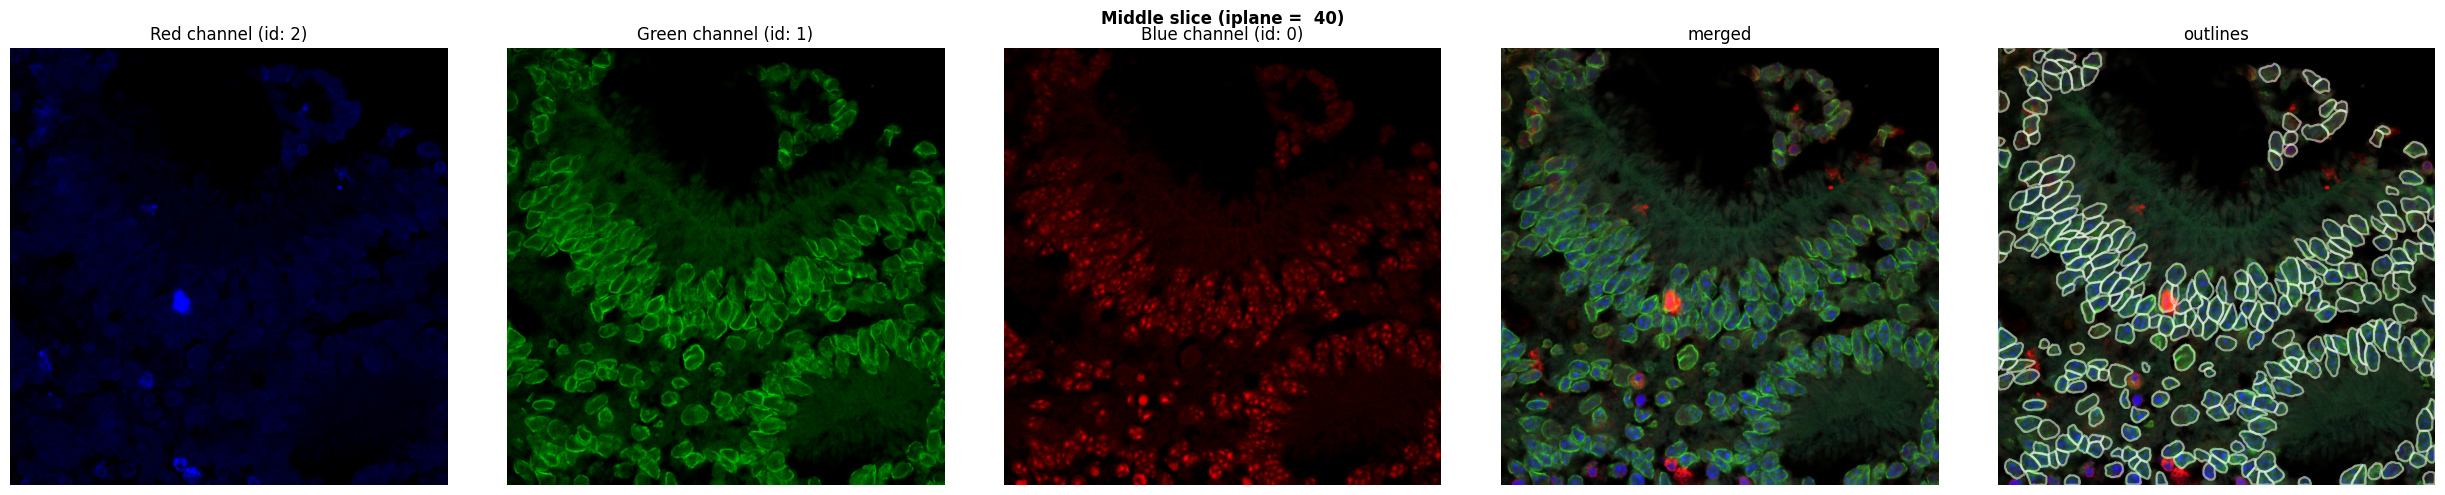

name                img_path                mask_path                                mask shape      
SPE_20230327_D25    SPE_20230327_D25.tif    SPE_20230327_D25_merge1_stitched.tiff    (80, 1024, 1024)



In [ ]:
#@markdown **Intensity channels and nuclear segmentation**
#@markdown <br>*also works for cellular segmentations.
name="SPE_20230327_D25"#@param {type:"string"}
img_path="/content/content/gdrive/MyDrive/msc-internship_HI_2024_vmp/00_raw_data/full_zstacks/SPE_20230327_D25.tif" #@param {type:"string"}
nuclear_nuclear_masks_path="/content/gdrive/MyDrive/msc-internship_HI_2024_vmp/02_results/04x1_merge_iteration1/SPE_20230327_D25_merge1_stitched.tiff" #@param {type:"string"}
img = skimage.io.imread(img_path) #shape: (80, 250, 250, 3)
masks = skimage.io.imread(nuclear_nuclear_masks_path) #shape: (80, 250, 250)

print("img shape (Z x X x Y x nchannels): ", img.shape)
print("masks shape (Z x X x Y): ", masks.shape)

nplanes = img.shape[0]
nchannels = img.shape[-1]

r_channel = 2
g_channel = 1
b_channel = 0

#init
iplane = round(nplanes/2)
stacked_plane = np.dstack((img[iplane,:,:,r_channel],
                           img[iplane,:,:,g_channel],
                           img[iplane,:,:,b_channel]))
imasks = masks[iplane, :,:]

#visualisation
fig, axes = plt.subplots(1,nchannels+2,figsize=(5*(nchannels+2),5))

axes[0].imshow(img[iplane,:,:,r_channel],cmap=rgb_map.get(0))
axes[0].set_title(f'Red channel (id: {r_channel})')
axes[0].axis(False)

axes[1].imshow(img[iplane,:,:,g_channel],cmap=rgb_map.get(1))
axes[1].set_title(f'Green channel (id: {g_channel})')
axes[1].axis(False)

axes[2].imshow(img[iplane,:,:,b_channel],cmap=rgb_map.get(2))
axes[2].set_title(f'Blue channel (id: {b_channel})')
axes[2].axis(False)

axes[3].imshow(stacked_plane)
axes[3].set_title('merged')
axes[3].axis(False)

axes[4].imshow(stacked_plane); axes[4].set_title("outlines")
for o in outlines_list(imasks):
    axes[4].plot(o[:,0], o[:,1], color='w', alpha=0.5)

for ax in axes:
    ax.axis("off")

plt.suptitle(f"Middle slice (iplane =  {iplane})", weight="bold")
plt.tight_layout()
plt.show();

# print meta data
data = [["name", "img_path", "mask_path","mask shape"]]
print_filename_only = True #@param {type:"boolean"}

if print_filename_only:
    row = [name, img_path.split('/')[-1], nuclear_nuclear_masks_path.split('/')[-1], masks.shape]
else:
    row = [name, img_path, nuclear_nuclear_masks_path, masks.shape]
data.append(row)

print_aligned_data(data)
print()

# Select channel for segmentation
- provide id of the channel which contains the nuclear spots

returns
- `channel_matrix`: np.array of dimensions `X` x `Y` of the selected channel.

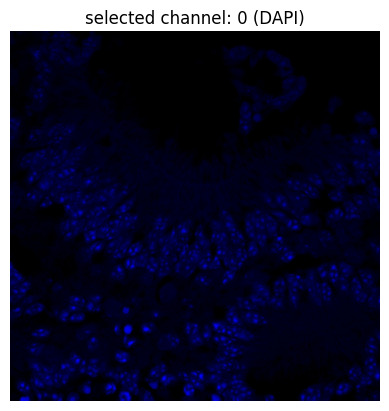

In [ ]:
selected_channel = 0 #@param {type:"number"}

channel_matrix = img[:,:,:,selected_channel].copy()

plt.imshow(channel_matrix[iplane, : , :],
           cmap=rgb_map.get(selected_channel),
           vmin=0, vmax=255)
plt.axis("off")
plt.title(f'selected channel: {selected_channel} ({channel_names[selected_channel]})')
plt.show();

# Testing parameters for your data
inspect which settings give the best visual results before running it on the entire stack.

In [ ]:
#@markdown windows_dict
WINDOWS_DICT = {"SPE_20230327_D25" : ((600, 800, 500, 700),
                                        (0, 200, 300, 500),
                                        (200, 400, 800, 1000),
                                        (0,1200,0,1200)),
                "SPE_20230327_D30" : ((400, 600, 600, 800),
                                        (800, 1000, 800, 1000),
                                        (100, 300, 100, 300),
                                        (0,1200,0,1200)),
                "SPE_20230327_D35" : ((0, 200, 800, 1000),
                                        (400, 600, 500, 700),
                                        (800, 1000, 200, 400),
                                        (0,1200,0,1200)),
                "SPE_20230327_D40" : ((100, 300, 500, 700),
                                        (800, 1000, 600, 800),
                                        (400, 600, 200, 400),
                                        (0,1200,0,1200))
                }

#windows = [(400, 600, 500, 700)]

windows= WINDOWS_DICT.get(name, [(0,1200,0,1200)])

## Pre-segmentation: image enhancement
Inspect the effects of image enhancement procedures on the middle plane of the stack

- gaussian blurring
- contrast enhancement: contrast clipping, gamma correction

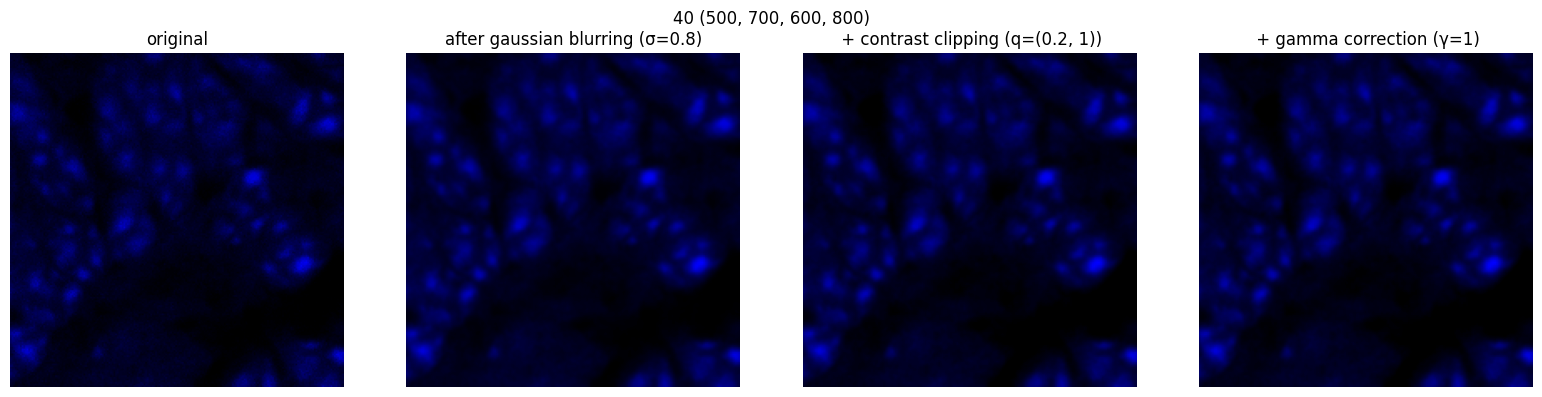

In [ ]:
#__parameters
#@markdown **subsection**
iplane = 40 #@param {type:'raw'}
y0, y1, x0, x1  = (600,800,500,700) #@param {type:'raw'}

#@markdown **gaussian blurring**
sigma = 0.8 # @param {type:"slider", min:0, max:5, step:0.1}

#@markdown **contrast clipping**
min_q = 0.2 # @param {type:"slider", min:0, max:1, step:0.005}
max_q = 1 # @param {type:"slider", min:0, max:1, step:0.005}

#@markdown **gamma correction**
gamma = 1 # @param {type:"slider", min:0, max:3, step:0.1}

#__data processing
test_img = copy.deepcopy(channel_matrix[iplane])

#gaussian blurring
smooth_img = skimage.filters.gaussian(test_img, sigma=sigma)

#contrast clipping
clipped_img = smooth_img.copy()
if (min_q, max_q) != (0, 1):
    vmin, vmax = np.quantile(smooth_img, q=(min_q, max_q))
    clipped_img = skimage.exposure.rescale_intensity(
                        smooth_img,
                        in_range=(vmin, vmax),
                        out_range=np.int8)
#gamma correction
gamma_img = clipped_img.copy()
if gamma != 1:
    gamma_img = skimage.exposure.adjust_gamma(clipped_img, gamma=gamma)

#__output
fig, axes = plt.subplots(1, 4, figsize=(16,4))
axes[0].imshow(test_img[x0:x1, y0:y1],
                cmap=rgb_map.get(selected_channel),
                vmin=0, vmax=255)
axes[0].set_title('original')
axes[0].axis("off")

axes[1].imshow(smooth_img[x0:x1, y0:y1],
                cmap=rgb_map.get(selected_channel))
axes[1].set_title(f'after gaussian blurring (σ={sigma})')
axes[1].axis("off")

axes[2].imshow(clipped_img[x0:x1, y0:y1],
                cmap=rgb_map.get(selected_channel))
axes[2].set_title(f' + contrast clipping (q={min_q, max_q})')
axes[2].axis("off")

axes[3].imshow(gamma_img[x0:x1, y0:y1],
                cmap=rgb_map.get(selected_channel))
axes[3].set_title(f' + gamma correction (γ={gamma})')
axes[3].axis("off")

plt.suptitle(f'{iplane} {x0, x1, y0, y1}')
plt.tight_layout()
plt.show();

## Segmentation
- inspect two- and three-level otsu thresholding performance on the enhanced test slice created previously.

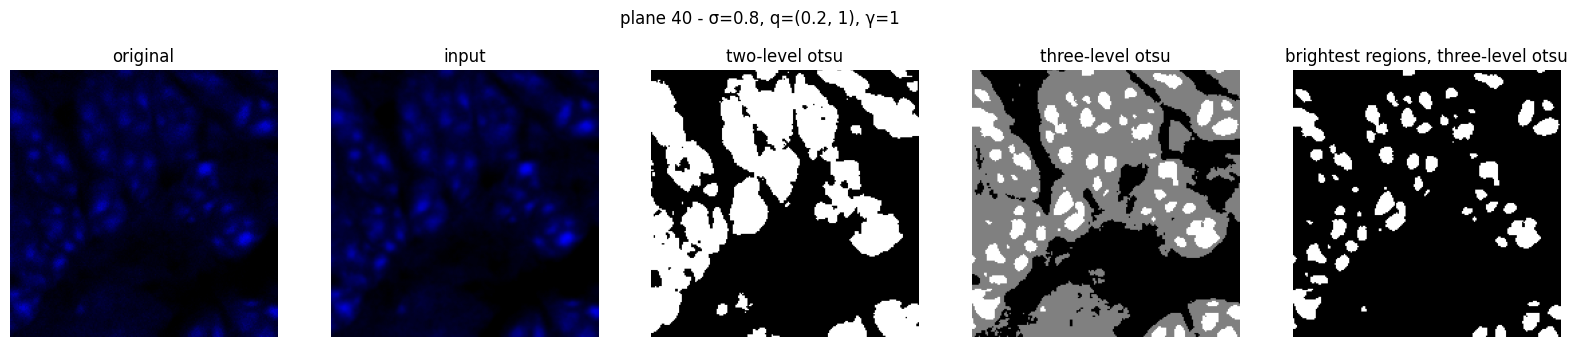

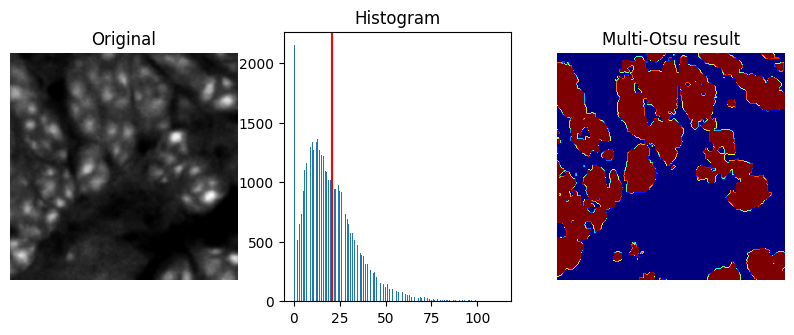

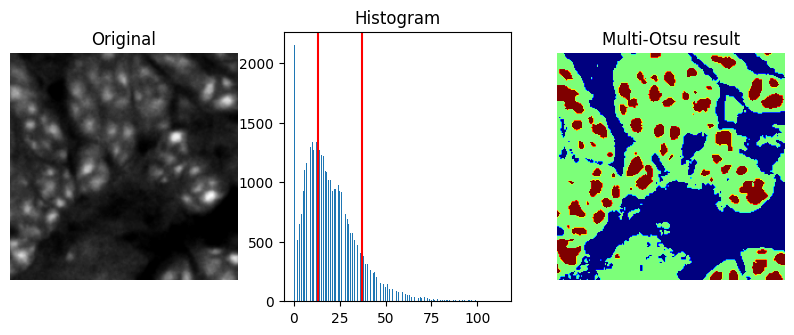

In [ ]:
#@markdown **visualisation options**
cmap_dict = {'grey':'gray',
             'colour':rgb_map.get(selected_channel)}
selected_cmap = 'grey' # @param ['grey', 'colour'] {type:"raw"}
cmap = cmap_dict[selected_cmap]

#two level
two_thresh = skimage.filters.threshold_otsu(gamma_img)
two_level = gamma_img > two_thresh


#three level
thresholds = skimage.filters.threshold_multiotsu(gamma_img)
three_level = np.digitize(gamma_img, bins=thresholds)

brightest_three_level = three_level.copy()
brightest_three_level[brightest_three_level == 1] = 0
brightest_three_level[brightest_three_level == 2] = 1

#__output
fig, axes = plt.subplots(1, 5, figsize=(20,4))

axes[0].imshow(test_img[x0:x1, y0:y1],
                cmap=cmap_dict['colour'],
               vmin=0, vmax=255)
axes[0].set_title(f'original')
axes[0].axis("off")

axes[1].imshow(gamma_img[x0:x1, y0:y1],
                cmap=cmap_dict['colour'])#, vmin=0, vmax=255)
axes[1].set_title(f'input')
axes[1].axis("off")

axes[2].imshow(two_level[x0:x1, y0:y1], cmap=cmap)
axes[2].set_title(f'two-level otsu')
axes[2].axis("off")

axes[3].imshow(three_level[x0:x1, y0:y1], cmap=cmap)
axes[3].set_title(f'three-level otsu')
axes[3].axis("off")

axes[4].imshow(brightest_three_level[x0:x1, y0:y1], cmap=cmap)
axes[4].set_title(f'brightest regions, three-level otsu')
axes[4].axis("off")

plt.suptitle(f'plane {iplane} - σ={sigma}, q={min_q, max_q}, γ={gamma}')
plt.show();

#histogram
#_two-level otsu histogram
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(10, 3.5))
# Plotting the original image.
ax[0].imshow(gamma_img[x0:x1, y0:y1], cmap='gray')
ax[0].set_title('Original')
ax[0].axis('off')

#histogram of intensity values + otsu threshold
ax[1].hist(gamma_img[x0:x1, y0:y1].ravel(), bins=255)
ax[1].set_title('Histogram')
ax[1].axvline(two_thresh, color='r')

# Plotting the Two-level Otsu result.
ax[2].imshow(two_level[x0:x1, y0:y1], cmap='jet')
ax[2].set_title('Multi-Otsu result')
ax[2].axis('off')

plt.subplots_adjust()

plt.show();

#_three-level otsu histogram
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(10, 3.5))

# Plotting the original image.
ax[0].imshow(gamma_img[x0:x1, y0:y1], cmap='gray')
ax[0].set_title('Original')
ax[0].axis('off')

# histogram of intensity values + otsu threshold
ax[1].hist(gamma_img[x0:x1, y0:y1].ravel(), bins=255)
ax[1].set_title('Histogram')
for thresh in thresholds:
    ax[1].axvline(thresh, color='r')

# Plotting the Multi Otsu result.
ax[2].imshow(three_level[x0:x1, y0:y1], cmap='jet')
ax[2].set_title('Multi-Otsu result')
ax[2].axis('off')

plt.subplots_adjust()

plt.show();

##Post-segmentation refinement
- morphological opening

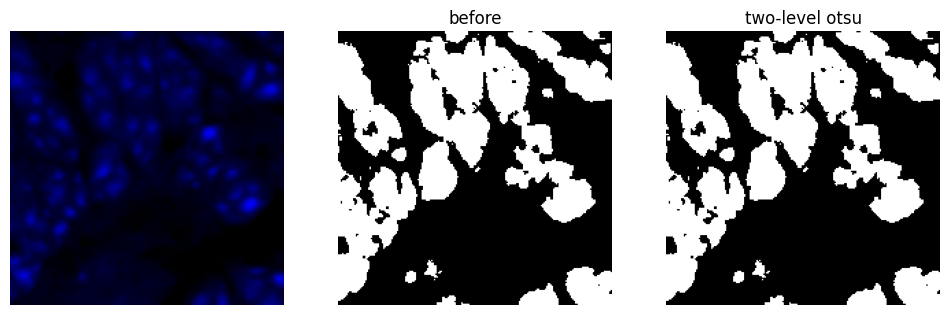

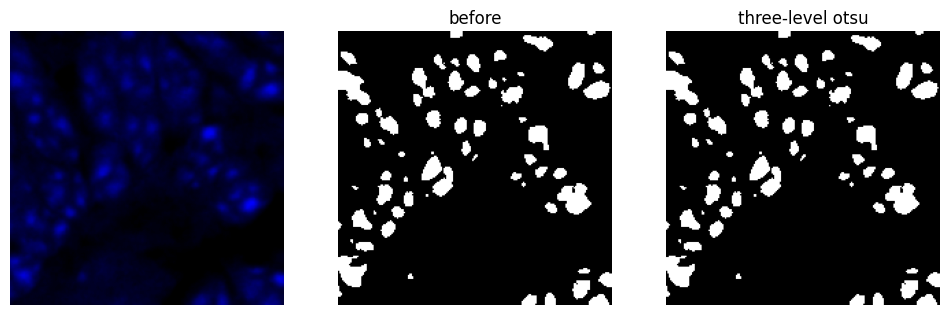

In [ ]:
#@markdown **erode/dilate options**
erode = 0 #@param {type:"number"}
dilate = 0 #@param {type:"number"}

#__data processing
two_smooth_matrix = two_level.copy()
three_smooth_matrix = brightest_three_level.copy()
if (erode, dilate) != (0,0):
    two_smooth_matrix = smooth(two_smooth_matrix, smooth_kernel=(2,2), erode=erode, dilate=dilate)
    three_smooth_matrix = smooth(three_smooth_matrix, smooth_kernel=(2,2), erode=erode, dilate=dilate)

#__output
fig, axes = plt.subplots(1, 3, figsize=(12,4))
axes[0].imshow(gamma_img[x0:x1, y0:y1],
                cmap=cmap_dict['colour'])
axes[1].imshow(two_level[x0:x1, y0:y1], cmap=cmap)
axes[1].set_title('before')
axes[2].imshow(two_smooth_matrix[x0:x1, y0:y1], cmap=cmap)
axes[2].set_title(f'after opening {erode, dilate}')
for ax in axes:
    ax.axis("off")
plt.title('two-level otsu')
plt.show()

fig, axes = plt.subplots(1, 3, figsize=(12,4))
axes[0].imshow(gamma_img[x0:x1, y0:y1],
                cmap=cmap_dict['colour'])
axes[1].imshow(brightest_three_level[x0:x1, y0:y1], cmap=cmap)
axes[1].set_title('before')
axes[2].imshow(three_smooth_matrix[x0:x1, y0:y1], cmap=cmap)
axes[2].set_title(f'after opening {erode, dilate}')
for ax in axes:
    ax.axis("off")
plt.title('three-level otsu')
plt.show()



## Testing instance segmentation

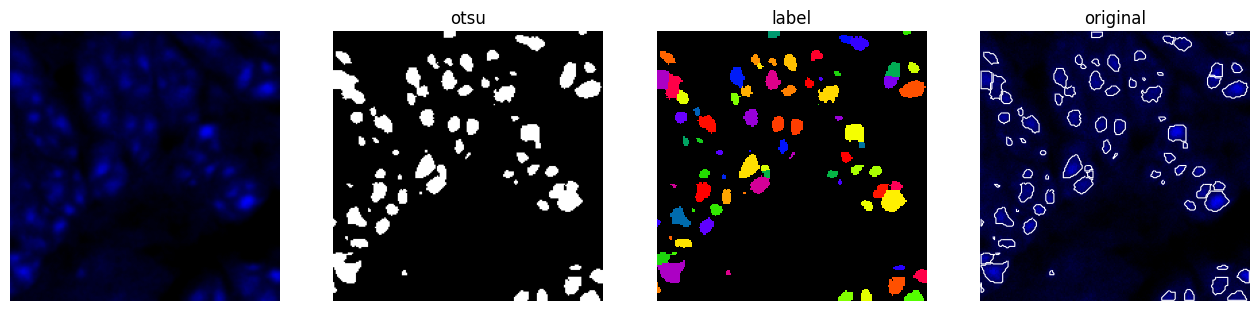

In [ ]:
#@markdown **segmentation options**<br>
#@markdown If algorithm: watershed, provide `compactness`, `instance_kernel`, `min_distance`.<br>
#@markdown If random_walker, provide `beta`.
selected_mode = 'multi' #@param ['multi', 'binary']
algorithm = "watershed" #@param ['none', 'watershed', 'random_walker']
compactness = 0 # @param {type:"number"}
instance_kernel = (6,6) #@param
min_distance = 4 #@param
beta = 130 #@param {type:"number"}

#data processing
otsu_matrix = three_smooth_matrix if selected_mode=='multi' else two_smooth_matrix
label_matrix = binarised2label(otsu_matrix, channel_matrix, algorithm, compactness, beta, instance_kernel, min_distance)

#__output
fig, axes = plt.subplots(1, 4, figsize=(16,4))
axes[0].imshow(gamma_img[x0:x1, y0:y1],
                cmap=cmap_dict['colour'])

axes[1].imshow(otsu_matrix[x0:x1, y0:y1], cmap=cmap)
axes[1].set_title('otsu')

# Create a new colormap of prism, but 0 == black
colors = plt.cm.prism(np.linspace(0, 1, 256))
colors[0] = [0, 0, 0, 1]  # Set the first color to black (with alpha = 1)
custom_cmap = mcolors.ListedColormap(colors)

axes[2].imshow(label_matrix[x0:x1, y0:y1], cmap=custom_cmap, interpolation='nearest')
axes[2].set_title(f'label')
for ax in axes:
    ax.axis("off")
plt.title('label')

axes[3].imshow(test_img[x0:x1, y0:y1], cmap=cmap_dict['colour'])
axes[3].set_title("original")
for o in outlines_list(label_matrix[x0:x1, y0:y1]):
    axes[3].plot(o[:,0], o[:,1], color='w',linewidth=0.8, alpha=1)

#plt.tight_layout()
plt.show();



# Parameter selection

**Description**<br>
selection based on
- inspection of a few planes (user specifies the iplanes -- here: top, middle, bottom)
- whether foci are correctly separated in small subsections


**Output**<br>
for each selected iplane
1. merged intensity matrix
2. selected channel intensity matrix
3. binarised matrix
4. smoothed matrix
5. label matrix - rainbow


Erosion and dilation

**user input**
- smooth_kernel (tup (int, int)) - the smaller the kernel size, the more details are retained. Increasing kernel size likely leads to merging of regions.
- erode, dilate (int) - number of iterations for the erosion and dilation process.

In [275]:
#@markdown **data**
selected_channel = 0 #@param {type:"number"}

#@markdown **gaussian smoothing options**
smooth_per_plane=True #@param {type:'boolean'}
sigma = 0.8 #@param {type:'raw'}
#@markdown **contrast options**
separate_planes_contrast = True #@param {type:"boolean"}
min_q = 0.2 # @param {type:"number"}
max_q = 1 # @param {type:"number"}
gamma = 1 #@param

#@markdown **otsu options**
separate_planes_otsu = True #@param {type:"boolean"}
otsu_within_regions = False #@param {type:"boolean"}
mode= 'multi' #@param ['binary', 'multi']
mask_matrix = (masks if otsu_within_regions else None)

#@markdown **Morphological opening/closing options**
enable_morphological_transformation=False #@param {type:'boolean'}
smooth_kernel=(2,2) #@param {type:"raw"}
erode = 2 #@param {type:"number"}
dilate = 2 #@param {type:"number"}
order_erosion_dilation = 'first_erode' #@param ['first_erode', 'first_dilate']

#store used parameters
options_dict = {
    "data": {
        "img_path": img_path,
        "mask_path": nuclear_nuclear_masks_path
    },
    "selected_channel": selected_channel,
    "img_enhancement": {
        'smooth_per_plane':smooth_per_plane,
        "sigma" : sigma,
        "separate_planes_contrast":separate_planes_contrast,
        "min_q": min_q,
        "max_q": max_q,
        "gamma": gamma
    },
    "otsu_options": {
        "separate_planes_otsu":separate_planes_otsu,
        "otsu_within_regions": otsu_within_regions,
        "mode":mode
    },
    "morphological_options": {
        "enable_morphological_transformation":enable_morphological_transformation,
        "smooth_kernel": smooth_kernel,
        "erode": erode,
        "dilate": dilate,
        "order_erosion_dilation": order_erosion_dilation
    }
}
print(f"\nOutput will be saved in '{output_dir}'")
pprint(options_dict)


Output will be saved in 'sub_output'
{'data': {'img_path': '/content/content/gdrive/MyDrive/msc-internship_HI_2024_vmp/00_raw_data/full_zstacks/SPE_20230327_D25.tif',
          'mask_path': '/content/gdrive/MyDrive/msc-internship_HI_2024_vmp/02_results/04x1_merge_iteration1/SPE_20230327_D25_merge1_stitched.tiff'},
 'img_enhancement': {'gamma': 1,
                     'max_q': 1,
                     'min_q': 0.2,
                     'separate_planes_contrast': True,
                     'sigma': 0.8,
                     'smooth_per_plane': True},
 'morphological_options': {'dilate': 2,
                           'enable_morphological_transformation': False,
                           'erode': 2,
                           'order_erosion_dilation': 'first_erode',
                           'smooth_kernel': (2, 2)},
 'otsu_options': {'mode': 'multi',
                  'otsu_within_regions': False,
                  'separate_planes_otsu': True},
 'selected_channel': 0}


# Binarisation (Semantic segmentation) - entire stack
code below contains blocks for
- Gaussian smoothing
- Increasing exposure
- Binarising with otsu thresholding. In case multi-level otsu is selected, the most intense class is retained for downstream processes.
- Applying morphological transformations

In [276]:
#@markdown [code]
# process
print(f"{datetime.now()}\tStarted processing")
channel_matrix = img[:,:,:,selected_channel].copy()

#gaussian smoothing
print(f"{datetime.now()}\t\tGaussian smoothing")
if sigma !=0:
    smooth_img = gaussian_smooth(channel_matrix, sigma,
                                smooth_per_plane=smooth_per_plane)
else:
    smooth_img = copy.deepcopy(channel_matrix)

#img enhancement
if (min_q, max_q) != (0,1):
    print(f"{datetime.now()}\t\tIncreasing exposure")
    if separate_planes_contrast:
        contrast_matrix = increase_exposure_per_plane(smooth_img, (min_q, max_q), gamma, show=False)
    else:
        contrast_matrix = increase_exposure(smooth_img, (min_q, max_q), gamma, show=False)
else:
    contrast_matrix = copy.deepcopy(smooth_img)

#otsu thresholding
print(f"{datetime.now()}\t\tBinarising with otsu thresholding")
if separate_planes_otsu:
    otsu_matrix = binarise_with_otsu_per_plane(contrast_matrix, mask_matrix, mode, verbose=False)
else:
    otsu_matrix = binarise_with_otsu(contrast_matrix, mask_matrix, mode, verbose=False)

if mode=='multi': #retain brightest regions
    otsu_matrix[otsu_matrix == 1] = 0
    otsu_matrix[otsu_matrix == 2] = 1

#morphological transformation
if enable_morphological_transformation:
    print(f"{datetime.now()}\t\tApplying morphological transformations")
    smooth_matrix = smooth(otsu_matrix, smooth_kernel, erode, dilate, order_erosion_dilation)
else:
    smooth_matrix=copy.deepcopy(otsu_matrix)

print(f"{datetime.now()}\tFinished processing")

2024-07-04 13:42:10.867512	Started processing
2024-07-04 13:42:10.948283		Gaussian smoothing
2024-07-04 13:42:14.613932		Increasing exposure
2024-07-04 13:42:16.519156		Binarising with otsu thresholding
2024-07-04 13:42:19.498024	Finished processing


# Closer inspection of smaller subsection(s)

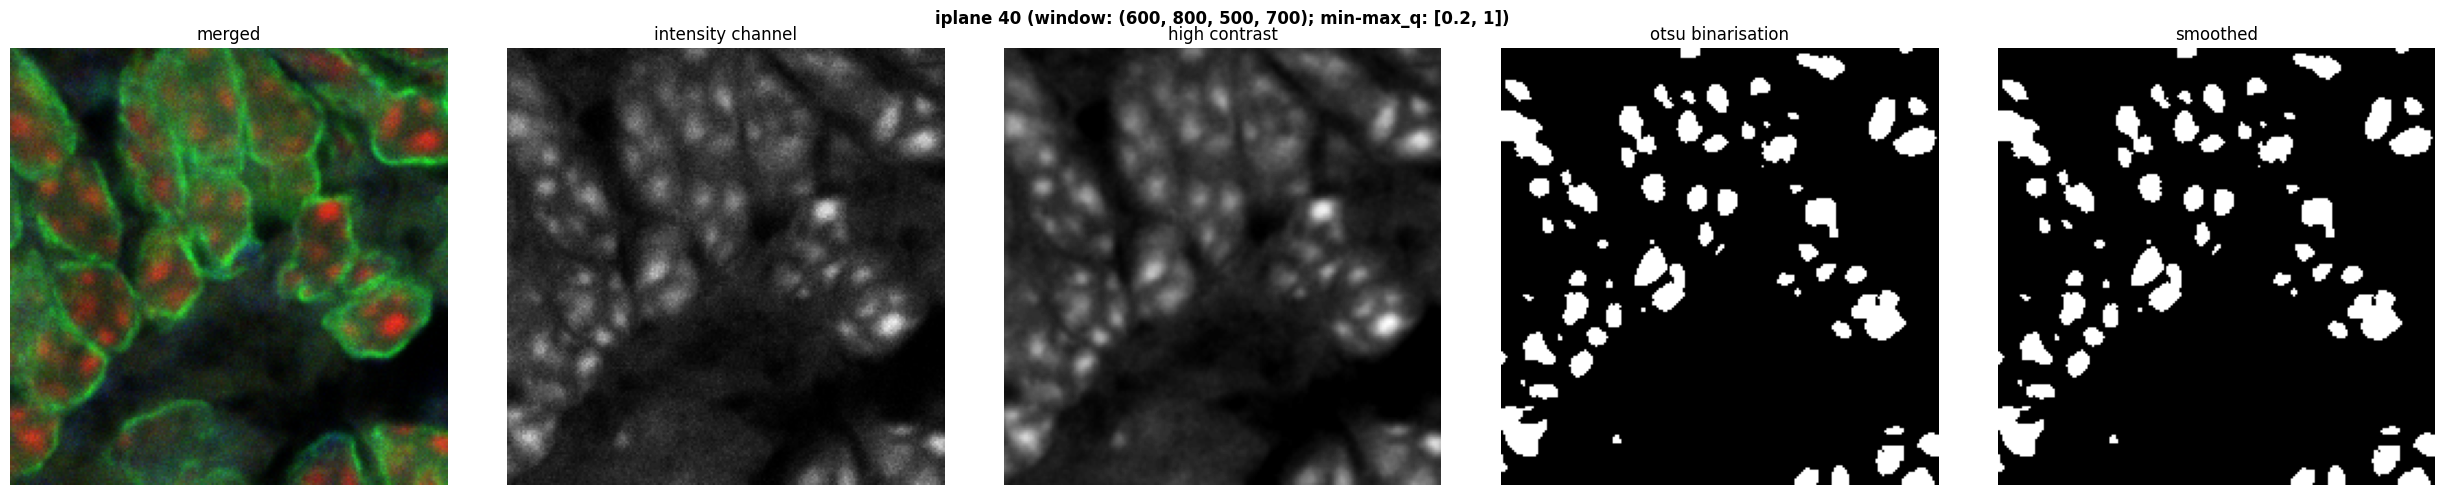

In [277]:
#@markdown **visualisation options**
iplanes_plot = range(40,41) #@param {type:"raw"}
window_idx = 0 #@param
save = False  #f"{name}_{window}_{iplane_plot}.png" #@param
xy_inverted = True #@param {type:"boolean"}
for window in [windows[window_idx]]:
    for iplane_plot in iplanes_plot:
        plot_binarisation_progress(iplane_plot, img, nchannels, channel_matrix,
                                   contrast_matrix, otsu_matrix, smooth_matrix,
                                   window=window, xy_inverted=xy_inverted,
                                   save=save)

#Showing x-y subsections of the stack

> dev note:

        >2023_D25
        windows= ((600, 800, 500, 700),
                (0, 200, 300, 500),
                (200, 400, 800, 1000),
                (0,1200,0,1200))

        >2023_D25
        windows= ((400, 600, 600, 800),
                (800, 1000, 800, 1000),
                (100, 300, 100, 300),
                (0,1200,0,1200))

        >2023_D35
        windows= ((0, 200, 800, 1000),
                (400, 600, 500, 700),
                (800, 1000, 200, 400),
                (0,1200,0,1200))

        >2023_D40
        windows= ((100, 300, 500, 700),
                (800, 1000, 600, 800),
                (400, 600, 200, 400),
                (0,1200,0,1200))

        >2024_D35
        windows= ((0, 200, 100, 300),
                (500, 700, 700, 900),
                (600, 800, 100, 300),
                (0,1200,0,1200))

## Instance segmentation - inspection selected subsection

**Instructions**<br>
Continue if the binarisation looks good.

**effect compactness**

**effect instance_kernel**<br>
sensitivity for establishing predicted centrepoints<br>
the bigger the kernel size, the less sensitive


**effect min_distance**<br>
minimum number of pixels for separation of two predicted centrepoints. (if distance is below min_distance, the centrepoints are considered 1 basin)

**effect beta**<br>
*not applicable to watershed*

In [278]:
#@markdown **segmentation options**<br>
#@markdown If algorithm: watershed, provide `compactness`, `instance_kernel`, `min_distance`.<br>
#@markdown If random_walker, provide `beta`.
algorithm = "watershed" #@param ['none', 'watershed', 'random_walker']
compactness = 0 # @param {type:"number"}
instance_kernel = (6,6) #@param
min_distance = 4 #@param
beta = 130 #@param {type:"number"}

options_dict["segmentation_options"] = {
        "algorithm": algorithm,
        "compactness": compactness,
        "beta": beta,
        "instance_kernel": instance_kernel,
        "min_distance": min_distance
    }

print(options_dict["segmentation_options"])

{'algorithm': 'watershed', 'compactness': 0, 'beta': 130, 'instance_kernel': (6, 6), 'min_distance': 4}


{'algorithm': 'watershed', 'compactness': 0, 'beta': 130, 'instance_kernel': (6, 6), 'min_distance': 4}
window:  (600, 800, 500, 700)


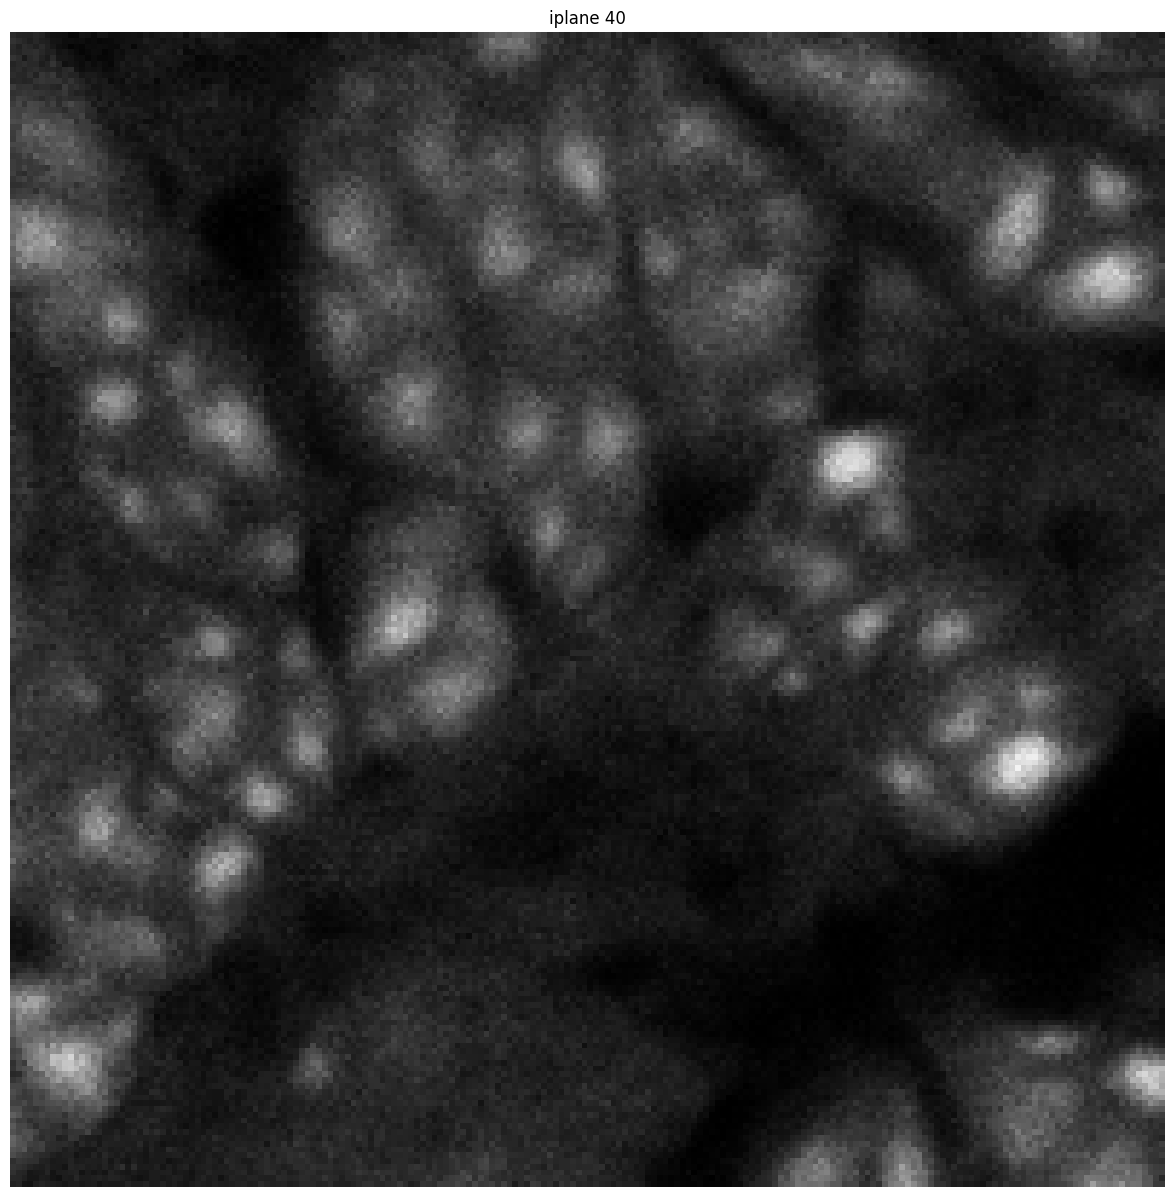

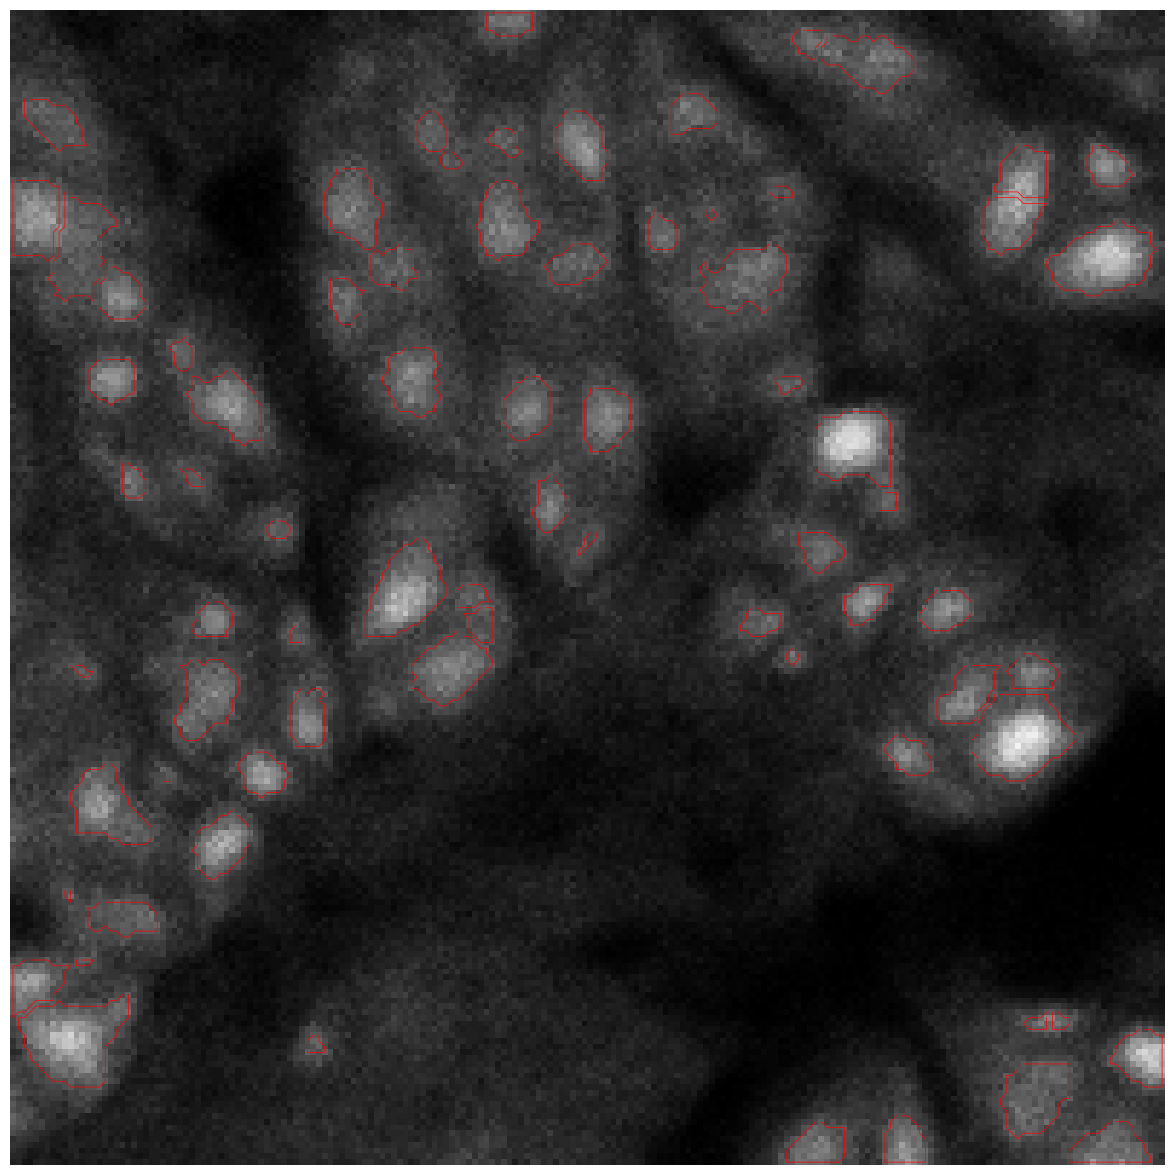

window:  (0, 200, 300, 500)


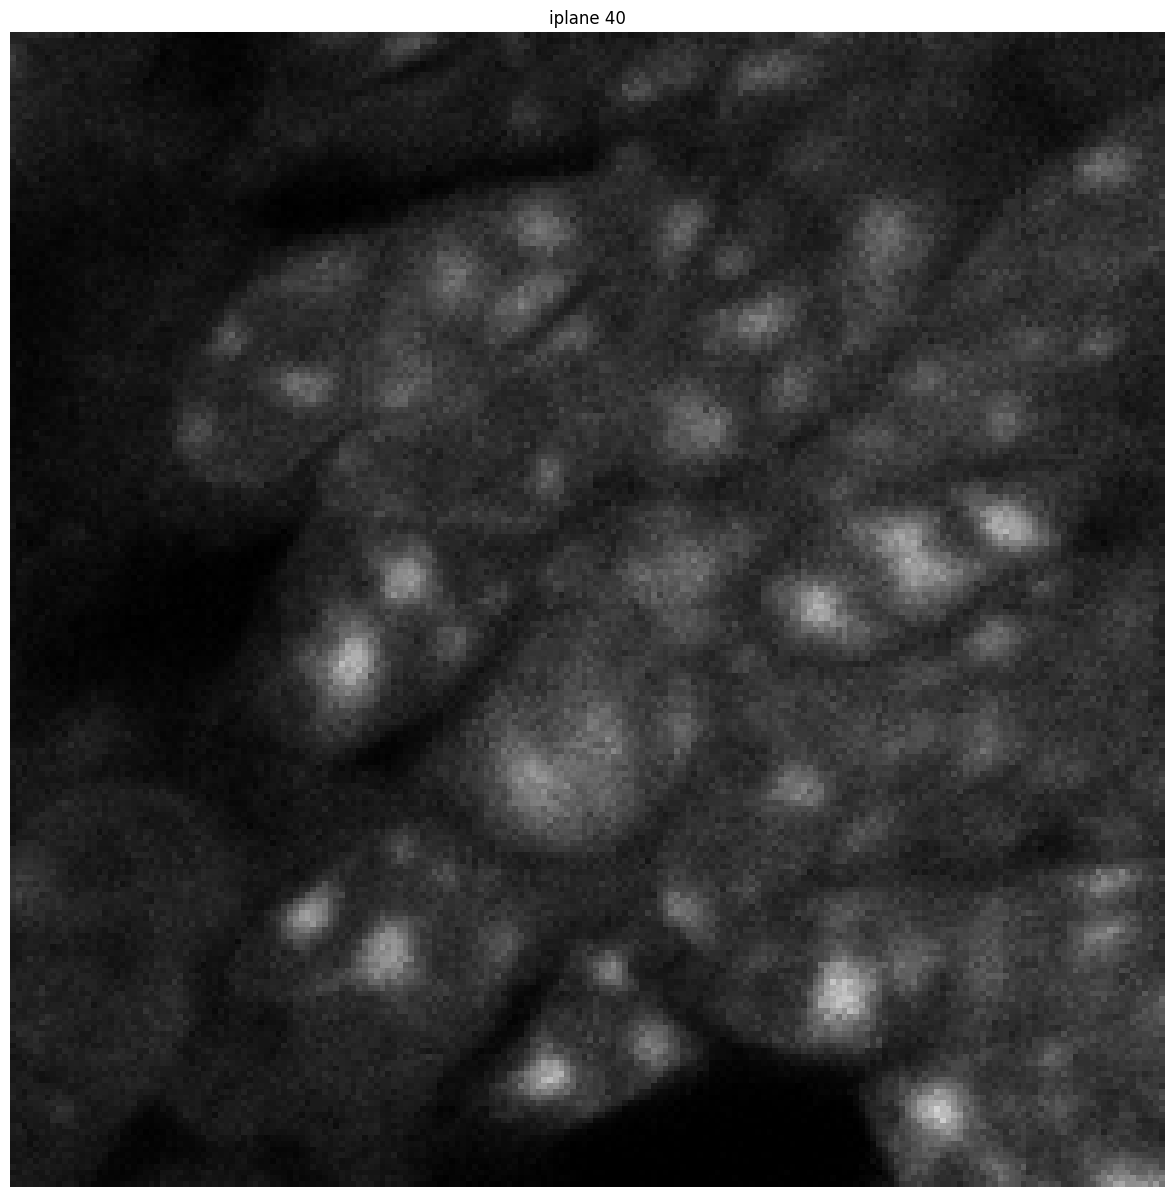

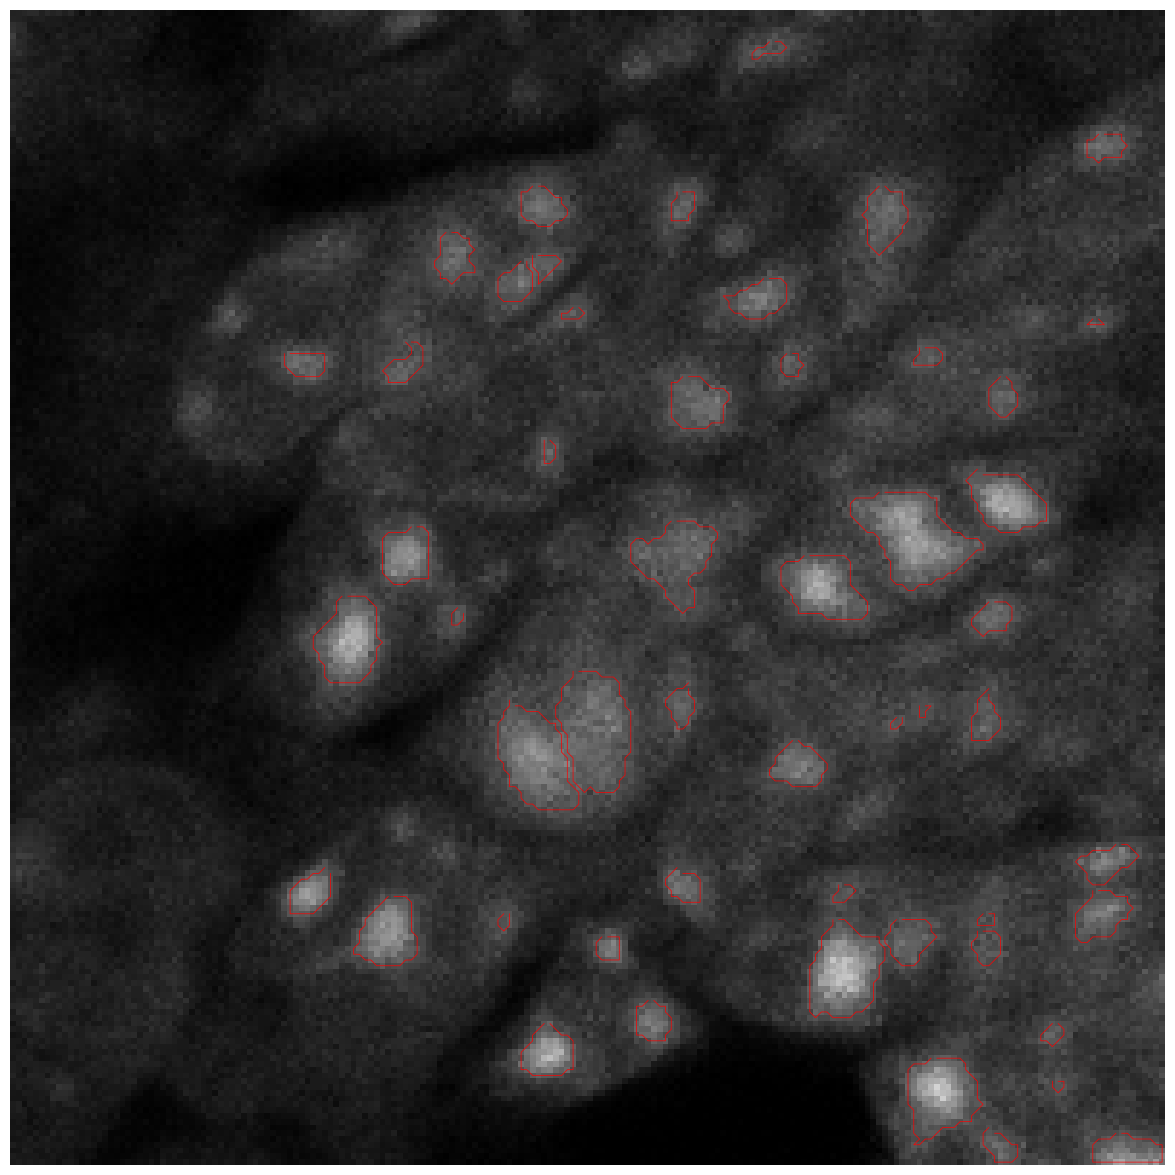

window:  (200, 400, 800, 1000)


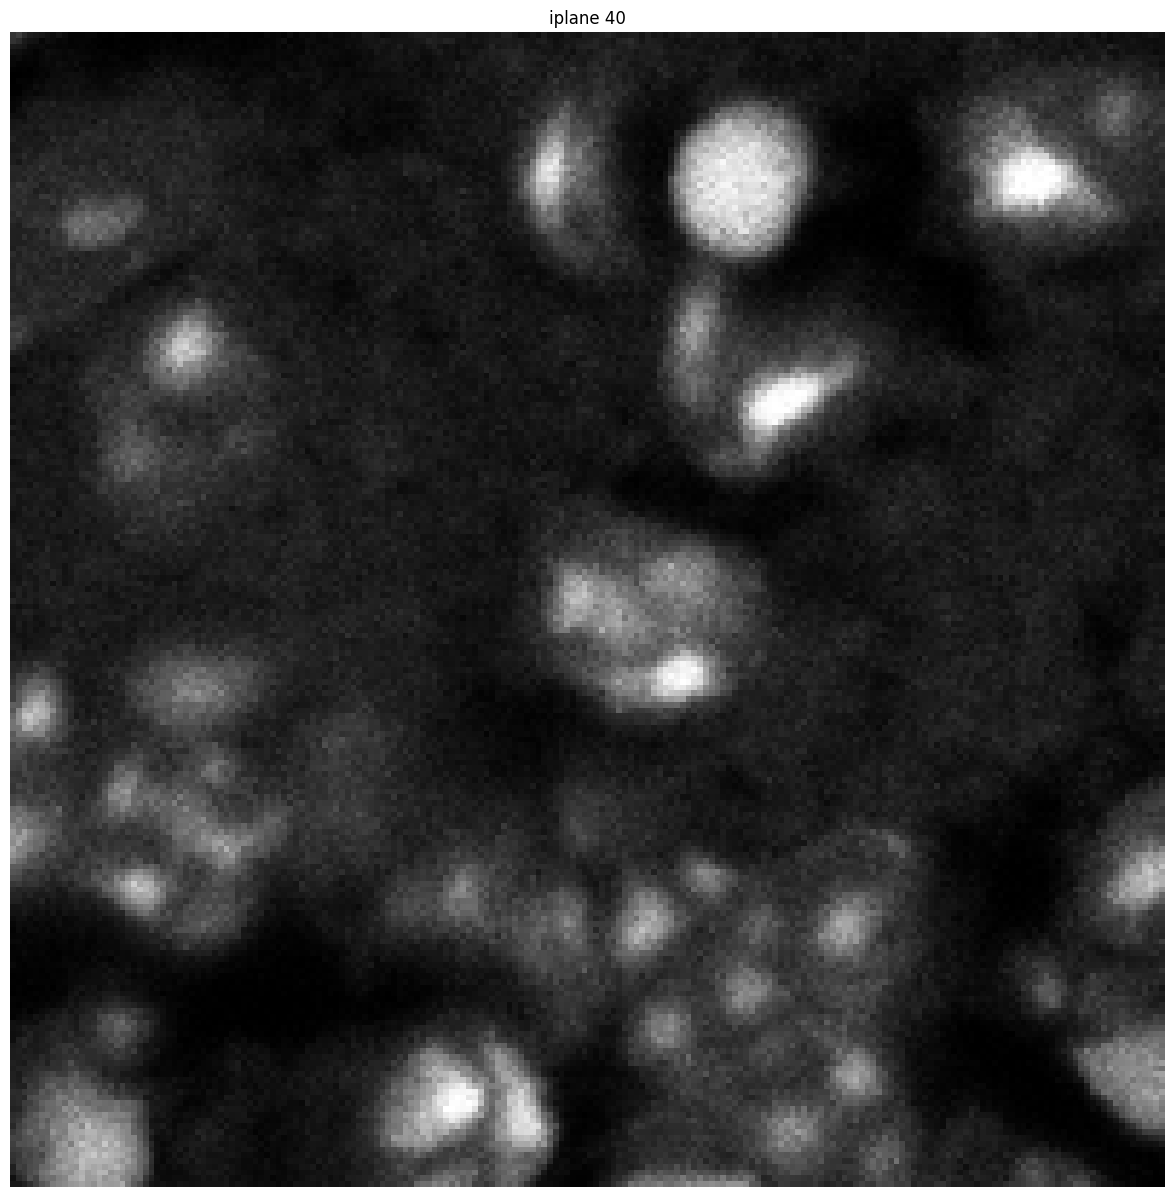

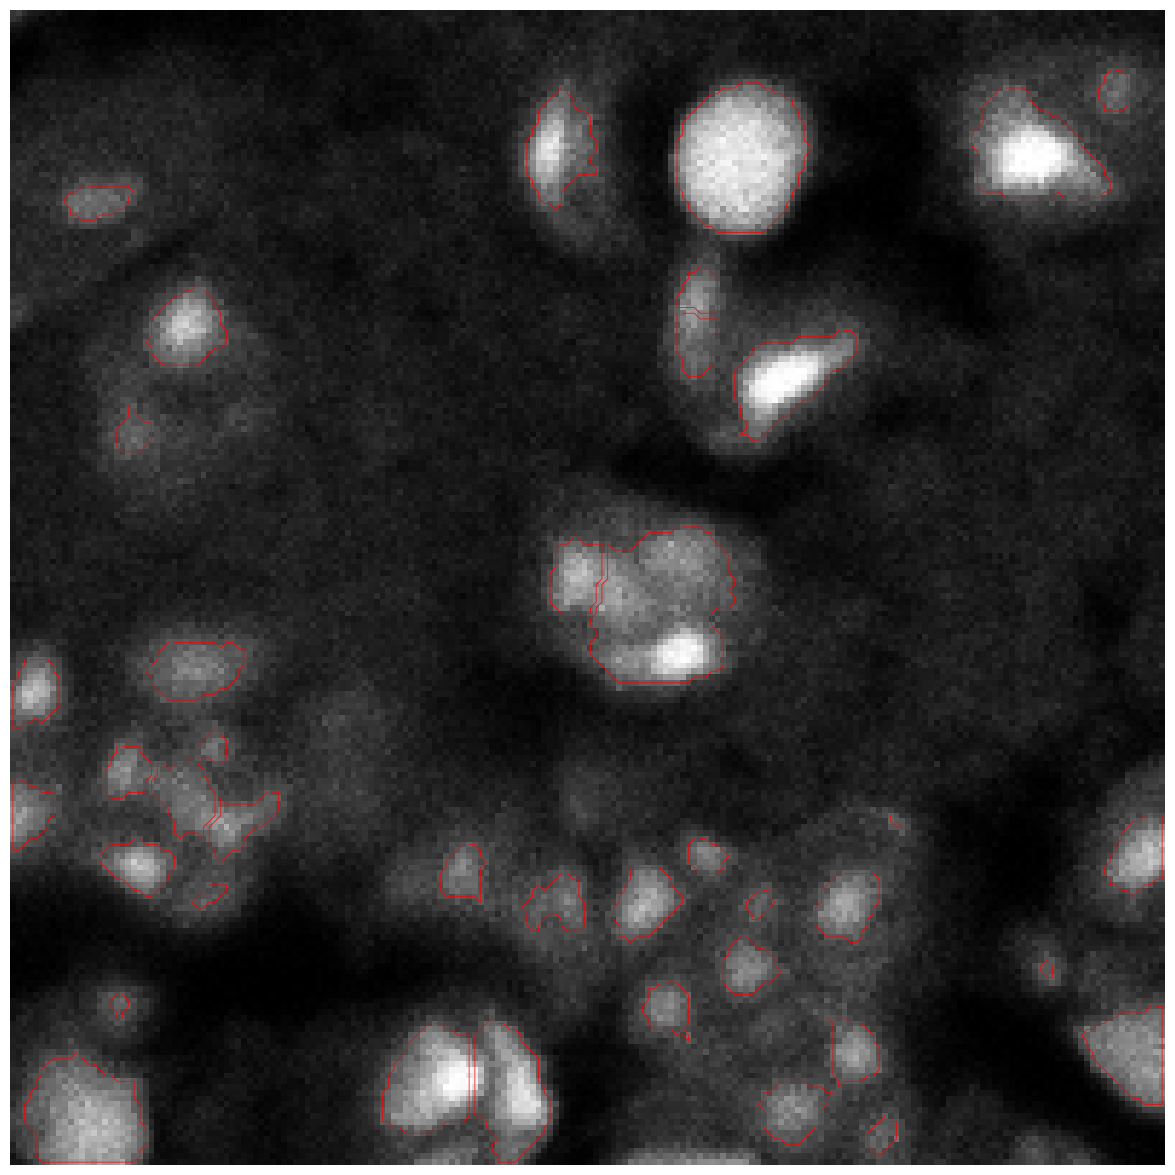

In [279]:
iplanes_plot = [round(nplanes/2)] #@param
window_idx = 0 #@param {type:'raw'}
show_segmentation = False #@param {type:"boolean"}
show_smooth = False  #@param {type:"boolean"}
show_otsu = False  #@param {type:"boolean"}
show_enhanced = False  #@param {type:"boolean"}
show_raw = True  #@param {type:"boolean"}
show_overlay = True  #@param {type:"boolean"}

#subsection
print(options_dict["segmentation_options"])

for window in windows[:-1]:
    print('window: ', window)
    x0, x1, y0, y1 = window
    label_matrix = binarised2label_3d(otsu_matrix[:, y0:y1, x0:x1], channel_matrix[:, y0:y1, x0:x1], algorithm, compactness, beta, instance_kernel, min_distance)

    if show_segmentation:
        #show segmentation
        plt.figure(figsize=(len(iplanes_plot)*5, 5))
        for idx, iplane in enumerate(iplanes_plot, 1):
            plt.subplot(1, len(iplanes_plot), idx)
            plt.imshow(skimage.color.label2rgb(label=label_matrix[iplane, :, :],
                                                        image=None,
                                                        bg_label=0,
                                                        bg_color=None,
                                                        kind='overlay',
                                                        alpha=0.6))
            plt.axis('off')
            plt.title(f"iplane {iplane}")

    plt.show()

    if show_smooth:
        #show smooth matrix
        plt.figure(figsize=(len(iplanes_plot)*5, 5))
        for idx, iplane in enumerate(iplanes_plot, 1):
            plt.subplot(1, len(iplanes_plot), idx)
            plt.imshow(smooth_matrix[iplane, y0:y1, x0:x1], cmap='gray')
            plt.axis('off')
            plt.title(f"iplane {iplane}")

        plt.show()

    if show_otsu:
        #show otsu matrix
        plt.figure(figsize=(len(iplanes_plot)*5, 5))
        for idx, iplane in enumerate(iplanes_plot, 1):
            plt.subplot(1, len(iplanes_plot), idx)
            plt.imshow(otsu_matrix[iplane, y0:y1, x0:x1], cmap='gray')
            plt.axis('off')
            plt.title(f"iplane {iplane}")

        plt.show()

    if show_enhanced:
        #show enhanced matrix
        plt.figure(figsize=(len(iplanes_plot)*5, 5))
        for idx, iplane in enumerate(iplanes_plot, 1):
            plt.subplot(1, len(iplanes_plot), idx)
            plt.imshow(contrast_matrix[iplane, y0:y1, x0:x1], cmap='gray')
            plt.axis('off')
            plt.title(f"iplane {iplane}")

        plt.show()

    if show_raw:
        #show raw intensity channel
        plt.figure(figsize=(len(iplanes_plot)*5, 5) if len(iplanes_plot)>1 else (15,15))
        for idx, iplane in enumerate(iplanes_plot, 1):
            plt.subplot(1, len(iplanes_plot), idx)
            plt.imshow(channel_matrix[iplane, y0:y1, x0:x1], cmap='gray', vmin=0, vmax=255)
            plt.axis('off')
            plt.title(f"iplane {iplane}")

        plt.savefig(f'{name}_{x0,x1,y0,y1}_raw.png')
        plt.show()

    if show_overlay:
        plt.figure(figsize=(len(iplanes_plot)*5, 5) if len(iplanes_plot)>1 else (15,15))
        for idx, iplane in enumerate(iplanes_plot, 1):
            plt.subplot(1, len(iplanes_plot), idx)
            plt.imshow(skimage.color.label2rgb(label=label_matrix[iplane, :, :],
                                                image=channel_matrix[iplane, y0:y1, x0:x1],
                                                bg_label=0,
                                                bg_color=None,
                                                kind='overlay',
                                                alpha=0.6))
            plt.axis('off')
            #plt.title(f"iplane {iplane}")
            plt.subplot(1, len(iplanes_plot), idx)
            plt.imshow(channel_matrix[iplane, y0:y1, x0:x1], cmap='gray', vmin=0, vmax=255)
            for o in outlines_list(label_matrix[iplane, :, :]):
                plt.plot(o[:, 0], o[:, 1], linewidth=0.5, color='red')

        plt.savefig(f'{name}_{x0,x1,y0,y1}_instancesegmented_{list(options_dict["segmentation_options"].values())}.png')
        plt.show();

# Offset the labels.
**This is relevant if you use the binarisation method of otsu+erosion/dilation.**

Due to the processing steps, the labels could've shifted slightly. Manually tweak the offset to align the labels with the intensity channel again.

after x offset:  (79, 1024, 1024)
after y offset:  (79, 1024, 1024)


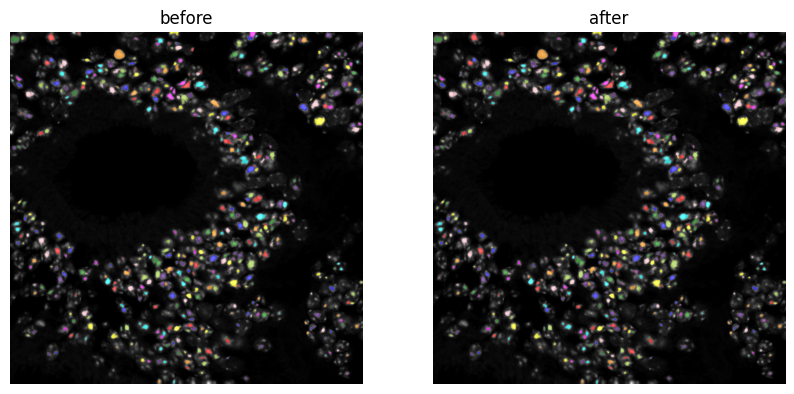

In [ ]:
#@markdown Find the right settings.
offset_x = 0 #@param
offset_y = 0 #@param
adjusted_matrix = shift_labels(label_matrix, offset_x, offset_y)

plt.figure(figsize=(10,5))
#show before
plt.subplot(1,2,1)
plt.imshow(skimage.color.label2rgb(label=label_matrix[iplane, :, :],
                                    image=contrast_smooth_img[iplane, y0:y1, x0:x1],
                                    bg_label=0,
                                    bg_color=None,
                                    kind='overlay',
                                    alpha=0.6))
plt.axis('off')
plt.title(f"before")

#show after
plt.subplot(1,2,2)
plt.imshow(skimage.color.label2rgb(label=adjusted_matrix[iplane, :, :],
                                    image=contrast_smooth_img[iplane, y0:y1, x0:x1],
                                    bg_label=0,
                                    bg_color=None,
                                    kind='overlay',
                                    alpha=0.6))
plt.axis('off')
plt.title(f"after")

plt.show();

options_dict['offset'] = {"offset_x":offset_x, "offset_y": offset_y}

In [ ]:
#shift the intermediate matrices.
contrast_matrix = shift_labels(contrast_matrix, offset_x, offset_y)
otsu_matrix = shift_labels(otsu_matrix, offset_x, offset_y)
smooth_matrix = shift_labels(smooth_matrix, offset_x, offset_y)

#Inspection of all subsections

In [ ]:
iplanes_plot = range(1,79,5) #@param
show_segmentation = False #@param {type: "boolean"}
show_smooth = False  #@param {type:"boolean"}
show_otsu = False  #@param {type:"boolean"}
show_enhanced = False  #@param {type:"boolean"}
show_raw = False  #@param {type:"boolean"}
show_overlay = True #@param {type:"boolean"}
#subsection
for window in windows[:-1]:
    print('window: ', window)
    x0, x1, y0, y1 = window
    label_matrix = binarised2label_3d(smooth_matrix[:, y0:y1, x0:x1], channel_matrix[:, y0:y1, x0:x1], algorithm, compactness, beta, instance_kernel, min_distance)


    if show_segmentation:
        #show segmentation
        plt.figure(figsize=(len(iplanes_plot)*5, 5))
        for idx, iplane in enumerate(iplanes_plot, 1):
            plt.subplot(1, len(iplanes_plot), idx)
            plt.imshow(skimage.color.label2rgb(label=label_matrix[iplane, :, :],
                                                        image=None,
                                                        bg_label=0,
                                                        bg_color=None,
                                                        kind='overlay',
                                                        alpha=0.6))
            plt.axis('off')
            plt.title(f"iplane {iplane}")

        plt.show()

    if show_smooth:
        #show smooth matrix
        plt.figure(figsize=(len(iplanes_plot)*5, 5))
        for idx, iplane in enumerate(iplanes_plot, 1):
            plt.subplot(1, len(iplanes_plot), idx)
            plt.imshow(smooth_matrix[iplane, y0:y1, x0:x1], cmap='gray')
            plt.axis('off')
            plt.title(f"iplane {iplane}")

        plt.show()

    if show_otsu:
        #show otsu matrix
        plt.figure(figsize=(len(iplanes_plot)*5, 5))
        for idx, iplane in enumerate(iplanes_plot, 1):
            plt.subplot(1, len(iplanes_plot), idx)
            plt.imshow(otsu_matrix[iplane, y0:y1, x0:x1], cmap='gray')
            plt.axis('off')
            plt.title(f"iplane {iplane}")

        plt.show()

    if show_enhanced:
        #show enhanced matrix
        plt.figure(figsize=(len(iplanes_plot)*5, 5))
        for idx, iplane in enumerate(iplanes_plot, 1):
            plt.subplot(1, len(iplanes_plot), idx)
            plt.imshow(contrast_matrix[iplane, y0:y1, x0:x1], cmap='gray')
            plt.axis('off')
            plt.title(f"iplane {iplane}")

        plt.show()

    if show_raw:
        #show raw intensity channel
        plt.figure(figsize=(len(iplanes_plot)*5, 5))
        for idx, iplane in enumerate(iplanes_plot, 1):
            plt.subplot(1, len(iplanes_plot), idx)
            plt.imshow(img[iplane, y0:y1, x0:x1, 0], cmap='gray')
            plt.axis('off')
            plt.title(f"iplane {iplane}")

        plt.show()

    if show_overlay:
        plt.figure(figsize=(len(iplanes_plot)*5, 5))
        for idx, iplane in enumerate(iplanes_plot, 1):
            plt.subplot(1, len(iplanes_plot), idx)
            plt.imshow(skimage.color.label2rgb(label=label_matrix[iplane, :, :],
                                                image=channel_matrix[iplane, y0:y1, x0:x1],
                                                bg_label=0,
                                                bg_color=None,
                                                kind='overlay',
                                                alpha=0.6))
            plt.axis('off')
            plt.title(f"iplane {iplane}")

    plt.show()

# Instance segmentation entire stack if thresholds are good.

In [ ]:
#@markdown [code: instance segmentation]
print(f"{datetime.now()}\t\tInstance segmentation of entire Z*X*Y")
label_matrix = binarised2label_3d(otsu_matrix, channel_matrix, algorithm, compactness, beta, instance_kernel, min_distance)
print(f"{datetime.now()}\t\tFinished segmentation of entire Z*X*Y")

2024-05-31 02:39:30.275192		Instance segmentation of entire Z*X*Y
2024-05-31 02:40:25.657282		Finished segmentation of entire Z*X*Y


## Showing subsections

In [ ]:
#@markdown [code]
iplanes_plot = range(0,channel_matrix.shape[0], 1) #@param
alpha = 1 # @param {type:"slider", min:0, max:1, step:0.1}
save=True #@param {type:"boolean"}
xy_inverted=True

#plot
for window in windows[:-1]:
    if xy_inverted:
        window = (window[-2],window[-1],window[0],window[1])

    for iplane_plot in iplanes_plot:
        filename=f"{name}_{window}_{iplane_plot}_segmentations.png"
        plot_segmentation_planes(iplane_plot,
                                img,
                                channel_matrix,
                                contrast_matrix,
                                otsu_matrix,
                                smooth_matrix,
                                label_matrix,
                                masks=masks,
                                window=window,
                                bg_id=0,
                                alpha=alpha,
                                save=save,
                                output_dir=filename)

#Export label matrix


In [ ]:
output_dir = "/content/gdrive/MyDrive/msc-internship_HI_2024_vmp/02_results/05_foci_segmentation/multi_otsu/SPE_20230327_D25/"

In [ ]:
outname= f"{output_dir}/{name}_channel{selected_channel}_labels.tiff"
tifffile.imwrite(outname, label_matrix, bigtiff=True)
print(f"{datetime.now()}\tCreated {outname}.")

2024-05-31 02:40:38.504050	Created /content/gdrive/MyDrive/msc-internship_HI_2024_vmp/02_results/05_foci_segmentation/multi_otsu/SPE_20230327_D30//SPE_20230327_D30_channel0_labels.tiff.


In [ ]:
print("Settings:")
for key, value in options_dict.items():
    print(f"\t{key}: {value}")

Settings:
	data: {'img_path': '/content/content/gdrive/MyDrive/msc-internship_HI_2024_vmp/00_raw_data/full_zstacks/SPE_20230327_D30.tif', 'mask_path': '/content/gdrive/MyDrive/msc-internship_HI_2024_vmp/02_results/04x1_merge_iteration1/SPE_20230327_D30_merge1_stitched.tiff'}
	selected_channel: 0
	contrast_options: {'separate_planes_contrast': True, 'min_q': 0.005, 'max_q': 0.995, 'gamma': 1.5}
	otsu_options: {'separate_planes_otsu': True, 'otsu_within_regions': False}
	smooth_options: {'sigma': 0.5}
	segmentation_options: {'algorithm': 'watershed', 'compactness': 0, 'beta': 130, 'instance_kernel': (6, 6), 'min_distance': 4}
	offset: {'offset_x': 0, 'offset_y': 0}


In [ ]:
#json
output_file_path = f"{output_dir}/.settings_{name}.json"
with open(output_file_path, 'w') as json_file:
    json.dump(options_dict, json_file, indent=4)

print(f"{datetime.now()}\tCreated {output_file_path}")

2024-05-31 02:40:38.569431	Created /content/gdrive/MyDrive/msc-internship_HI_2024_vmp/02_results/05_foci_segmentation/multi_otsu/SPE_20230327_D30//.settings_SPE_20230327_D30.json


# Store intermediate files
- enhanced matrix
- otsu_matrix
- smooth_matrix

In [ ]:
#full
tifffile.imwrite(f"{name}_!full_smooth-matrix.tiff", smooth_img, bigtiff=True)
tifffile.imwrite(f"{name}_!full_smooth-contrast-matrix.tiff", contrast_smooth_img, bigtiff=True)
tifffile.imwrite(f"{name}_!full_multiotsu-matrix.tiff", multi_otsu_matrix, bigtiff=True)
#tifffile.imwrite(f"{name}_!full_otsu-matrix.tiff", otsu_matrix, bigtiff=True)


In [ ]:
# EXPORT FILES FROM THE SESSION DIR
!zip -r SPE_20230327_D25_dapi_matrices.zip *.tiff

  adding: SPE_20230327_D30_!full_multiotsu-matrix.tiff (deflated 99%)
  adding: SPE_20230327_D30_!full_smooth-contrast-matrix.tiff (deflated 61%)
  adding: SPE_20230327_D30_!full_smooth-matrix.tiff (deflated 6%)


In [ ]:
!mv /content/SPE_20230327_D25_dapi_matrices.zip $output_dir